In [59]:
'''Main'''
import numpy as np
import pandas as pd
import os

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep'''
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.compose import ColumnTransformer 
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import precision_recall_curve, average_precision_score,precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 

'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# Data Preparation

## Acquire Data

In [127]:
# We only get the train data set
current_path = os.getcwd()+"\\"
file = os.path.sep.join(["..\\data\\train.csv"])
data = pd.read_csv(current_path + file)
data=data.set_index("Id")

# signal is the target variable
X=data.drop(["signal","BUTTER"], axis=1) # Droping BUTTER variable as is IRRELEVANT
X.columns = X.columns.str.replace(' ', '')
y=pd.DataFrame(data["signal"])


## Explore Data

In [61]:
X.shape

(212662, 14)

In [62]:
X.head()

,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA
Id,,,,,,,,,,,,,,
0,28.878847,2.662533,2924.690991,0.999997,19085.568945,0.569198,-0.575502,0.581565,66850.893711,0.637969,14298.486178,7940.694301,2.628526,2.680116
1,34.233566,0.092746,346.948714,0.999997,6631.244546,0.248707,-0.615941,0.277898,39274.475071,0.148815,11553.163934,3904.681337,3.292504,3.085754
2,36.113632,2.442423,238.553023,0.999986,7740.918989,0.222347,0.249383,0.216576,27757.153899,0.249840,24081.196003,4738.891687,3.433676,3.121906
3,14.286133,6.337556,227.375132,0.999806,6740.281614,0.347316,0.591884,0.306927,10593.207077,0.400748,11343.521945,3308.943750,2.291867,2.200712
4,60.474274,7.632751,106.730650,0.999905,5556.388794,0.204273,0.655850,0.196600,11801.249543,0.223101,25940.693317,4026.326871,3.290073,3.281829


In [63]:
X.describe()

,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA
count,212662.000000,212662.000000,2.126620e+05,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000
mean,30.917255,2.831039,3.233108e+03,0.999962,9260.664335,0.573487,0.217185,0.581601,29740.464140,0.595178,23615.399265,5781.262866,3.149949,3.166745
std,15.392944,2.216654,1.498588e+04,0.000068,3997.768903,0.417256,0.484779,0.437939,19239.085505,0.460742,16424.509733,2669.985983,0.520862,0.527135
min,0.204442,0.000038,3.138746e+01,0.999500,2500.513932,0.200005,-0.799991,0.064412,3791.228140,0.053244,4952.118133,3000.031840,2.000000,2.000227
25%,19.250309,0.925412,3.851386e+02,0.999961,6527.503234,0.289879,-0.170048,0.292138,15356.298104,0.294970,11921.223058,3887.726863,2.752651,2.760779
50%,29.615744,2.287488,9.017917e+02,0.999989,8336.548930,0.429935,0.241336,0.436257,24379.336211,0.444553,18693.423754,4986.055993,3.128397,3.151240
75%,41.071903,4.426295,2.564877e+03,0.999998,11065.050625,0.703082,0.634683,0.713462,38994.138332,0.731249,30209.322530,6770.025065,3.526473,3.551590
max,108.067413,7.999920,1.971087e+06,1.000000,56327.186960,2.999445,0.999998,4.376841,99995.109721,4.439294,99982.936241,52715.201472,4.499751,4.499966


In [64]:
y.groupby('signal').signal.count()/y["signal"].count().sum()*100

signal
0.0    66.599581
1.0    33.400419
Name: signal, dtype: float64

## Feature engineering

In [65]:
cols=X.columns
Xc=X.copy()

for col1 in cols:
    for col2 in cols:
        Xc[col1+"x"+col2]=Xc[col1]*Xc[col2]

In [144]:
Xc=X.copy()
Xc["LOG_B_FDCHI2_OWNPV"]=np.log(Xc["B_FDCHI2_OWNPV"])
Xc=Xc.drop(["B_FDCHI2_OWNPV"],axis=1)
#Xc["EXP_B_DIRA_OWNPV"]=np.exp(Xc["B_DIRA_OWNPV"])

### Graphs!

In [66]:
db=pd.concat([Xc[supercols], y], axis=1, sort=False)

In [67]:
res=abs(db.corr()).sort_values(by="signal",ascending=False)

In [69]:
cols=X.columns
supercols=res.index[1:20]
supercols

Index(['Kst_892_0_cosThetaHxKst_892_0_cosThetaH', 'Kst_892_0_IP_OWNPVxKplus_P',
       'Kplus_PxKst_892_0_IP_OWNPV', 'Kplus_PxKplus_IP_OWNPV',
       'Kplus_IP_OWNPVxKplus_P', 'piminus_IP_OWNPVxKplus_P',
       'Kplus_Pxpiminus_IP_OWNPV', 'piminus_ETAxB_IPCHI2_OWNPV',
       'B_IPCHI2_OWNPVxpiminus_ETA', 'Kplus_ETAxB_IPCHI2_OWNPV',
       'B_IPCHI2_OWNPVxKplus_ETA', 'B_IPCHI2_OWNPV',
       'B_IPCHI2_OWNPVxB_DIRA_OWNPV', 'B_DIRA_OWNPVxB_IPCHI2_OWNPV',
       'Kst_892_0_IP_OWNPVxB_DIRA_OWNPV', 'B_DIRA_OWNPVxKst_892_0_IP_OWNPV',
       'Kst_892_0_IP_OWNPV', 'Kplus_IP_OWNPVxB_DIRA_OWNPV',
       'B_DIRA_OWNPVxKplus_IP_OWNPV'],
      dtype='object')

In [116]:
X.columns

Index(['B_OWNPV_CHI2', 'B_IPCHI2_OWNPV', 'B_FDCHI2_OWNPV', 'B_DIRA_OWNPV',
       'B_PT', 'Kst_892_0_IP_OWNPV', 'Kst_892_0_cosThetaH', 'Kplus_IP_OWNPV',
       'Kplus_P', 'piminus_IP_OWNPV', 'piminus_P', 'gamma_PT', 'piminus_ETA',
       'Kplus_ETA'],
      dtype='object')

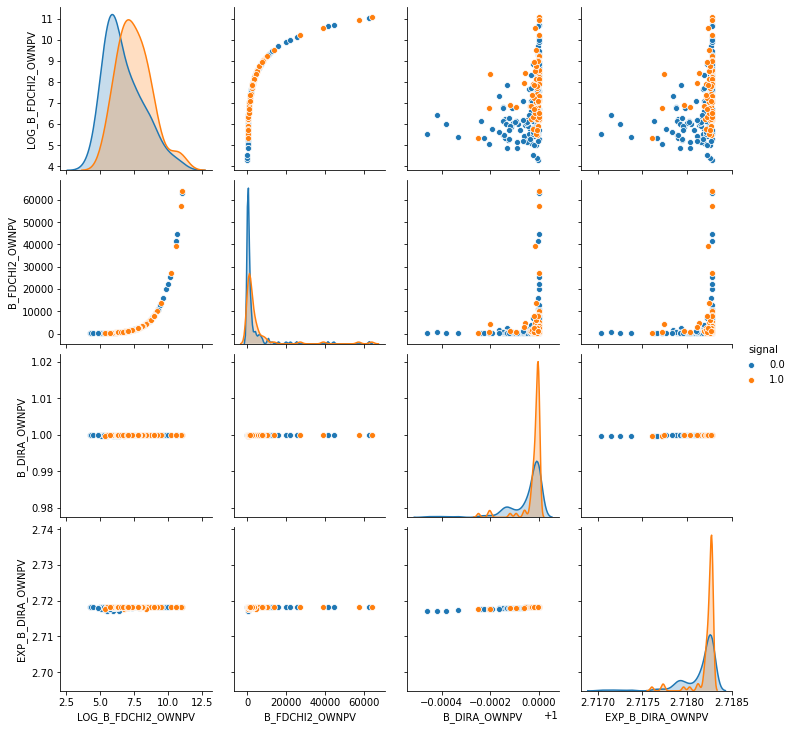

In [135]:
db=pd.concat((Xc[["LOG_B_FDCHI2_OWNPV","B_FDCHI2_OWNPV","B_DIRA_OWNPV","EXP_B_DIRA_OWNPV"]], y), axis=1, sort=False)
sns.pairplot(data=db[::1000],hue="signal")

## Scaling the data

In [10]:
#Standarazing all of the signal variables we could normalize them but this will be likely affected by the precense of outliers
X_scaled=X.copy()
scaler = StandardScaler() 
X_scaled[X_scaled.columns.values] = scaler.fit_transform(X_scaled[X_scaled.columns.values])

In [11]:
X_scaled.describe()

,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA
count,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05
mean,-7.689786e-17,-2.424404e-16,1.474989e-17,6.123766e-14,5.696404e-16,7.085084e-17,-1.214572e-17,1.904297e-16,-1.719373e-16,-1.490377e-16,-3.372423e-16,3.115288e-16,-7.637162e-16,4.556852e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.995257e+00,-1.277154e+00,-2.136496e-01,-6.768457e+00,-1.690985e+00,-8.950950e-01,-2.098233e+00,-1.180966e+00,-1.348780e+00,-1.176222e+00,-1.136309e+00,-1.041667e+00,-2.207787e+00,-2.212948e+00
25%,-7.579429e-01,-8.596884e-01,-1.900439e-01,-2.022793e-02,-6.836732e-01,-6.796995e-01,-7.987847e-01,-6.609699e-01,-7.476551e-01,-6.515771e-01,-7.119971e-01,-7.091949e-01,-7.627739e-01,-7.701401e-01
50%,-8.455265e-02,-2.452133e-01,-1.555679e-01,3.952731e-01,-2.311583e-01,-3.440399e-01,4.981935e-02,-3.318836e-01,-2.786588e-01,-3.269188e-01,-2.996733e-01,-2.978326e-01,-4.137858e-02,-2.941407e-02
75%,6.596966e-01,7.196702e-01,-4.459077e-02,5.145738e-01,4.513494e-01,3.105881e-01,8.612174e-01,3.010957e-01,4.809842e-01,2.953312e-01,4.014694e-01,3.703257e-01,7.228877e-01,7.300715e-01
max,5.012059e+00,2.331845e+00,1.313142e+02,5.505127e-01,1.177323e+01,5.814091e+00,1.614789e+00,8.666168e+00,3.651671e+00,8.343331e+00,4.649619e+00,1.757839e+01,2.591483e+00,2.529191e+00


Using **Robust Scaling** to avoid outliers effect when scaling

More info in: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

In [12]:
#Robust scaled to avoid outilers effect when normalizing: 
X_Rscaled=X.copy()
Rscaler = RobustScaler() 
X_Rscaled[X_Rscaled.columns.values] = Rscaler.fit_transform(X_Rscaled[X_Rscaled.columns.values])

In [13]:
X_Rscaled.describe()

,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA
count,2.126620e+05,212662.000000,2.126620e+05,2.126620e+05,212662.000000,2.126620e+05,2.126620e+05,212662.000000,2.126620e+05,2.126620e+05,212662.000000,2.126620e+05,212662.000000,212662.000000
mean,5.964327e-02,0.155261,1.069539e+00,-7.391022e-01,0.203660,3.474142e-01,-3.001162e-02,0.344970,2.268028e-01,3.452486e-01,0.269135,2.758933e-01,0.027852,0.019607
std,7.053996e-01,0.633170,6.875082e+00,1.869856e+00,0.881042,1.009810e+00,6.024103e-01,1.039433,8.139105e-01,1.056071e+00,0.898098,9.263393e-01,0.673102,0.666574
min,-1.347807e+00,-0.653392,-3.993158e-01,-1.339511e+01,-1.286165,-5.564596e-01,-1.294006e+00,-0.882562,-8.709809e-01,-8.969221e-01,-0.751380,-6.890419e-01,-1.458212,-1.455484
25%,-4.750081e-01,-0.389066,-2.370252e-01,-7.769254e-01,-0.398684,-3.389516e-01,-5.112066e-01,-0.342062,-3.817201e-01,-3.428614e-01,-0.370306,-3.810602e-01,-0.485572,-0.493748
50%,-8.140357e-17,0.000000,2.607809e-17,-1.519405e-12,0.000000,6.717183e-17,1.724517e-17,0.000000,-7.695210e-17,-6.361874e-17,0.000000,1.577725e-16,0.000000,0.000000
75%,5.249919e-01,0.610934,7.629748e-01,2.230746e-01,0.601316,6.610484e-01,4.887934e-01,0.657938,6.182799e-01,6.571386e-01,0.629694,6.189398e-01,0.514428,0.506252
max,3.595139e+00,1.631712,9.038630e+02,2.902751e-01,10.576339,6.218528e+00,9.427517e-01,9.352846,3.198929e+00,9.156377e+00,4.444940,1.655941e+01,1.772181,1.705496


# Model Training and testing

## Logistic regression

In [14]:
#Split between training and test
X_train, X_test, y_train, y_test = train_test_split(X_Rscaled, y, test_size=0.33)
k_fold = StratifiedKFold(n_splits=5,shuffle=True)

In [15]:
#penalty = 'l2'
#C = 1.0
#class_weight = 'balanced'
#n_jobs=1
#solver = 'liblinear'

#model = LogisticRegression(penalty=penalty, C=C,class_weight=class_weight,solver=solver, n_jobs=n_jobs)

IndentationError: unexpected indent (<ipython-input-15-22d20e0a0220>, line 8)

In [ ]:
model=LogisticRegression(C = 1.0)

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
                                          y_train.values.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    #model
    model.fit(X_train_fold,y_train_fold)
    
    print(model.score(X_train_fold,y_train_fold))
    print(model.score(X_cv_fold,y_cv_fold))
    print()


In [ ]:
score=model.score(X_test,y_test)
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [ ]:
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

## Random Forest

In [97]:
np.concatenate((cols, supercols[:2]),axis=0)

array(['B_OWNPV_CHI2', 'B_IPCHI2_OWNPV', 'B_FDCHI2_OWNPV', 'B_DIRA_OWNPV',
       'B_PT', 'Kst_892_0_IP_OWNPV', 'Kst_892_0_cosThetaH',
       'Kplus_IP_OWNPV', 'Kplus_P', 'piminus_IP_OWNPV', 'piminus_P',
       'gamma_PT', 'piminus_ETA', 'Kplus_ETA',
       'Kst_892_0_cosThetaHxKst_892_0_cosThetaH',
       'Kst_892_0_IP_OWNPVxKplus_P'], dtype=object)

In [149]:
#Split between training and test
Rscaler=RobustScaler()
Xc_Rscaled=pd.DataFrame(data=Rscaler.fit_transform(Xc))
X_train, X_test, y_train, y_test = train_test_split(X_Rscaled, y, test_size=0.4)
k_fold = StratifiedKFold(n_splits=5,shuffle=True)

In [150]:
model = RandomForestClassifier()

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.values.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    print(model.score(X_train_fold,y_train_fold))
    print(model.score(X_cv_fold,y_cv_fold))
    break
    


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


0.9999902034738481
0.7704937304075236


In [151]:
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

0.8346413315925487

## XGBoost

In [176]:
#Split between training and test
Xc_Rscaled=pd.DataFrame(data=Rscaler.fit_transform(Xc))
X_train, X_test, y_train, y_test = train_test_split(Xc_Rscaled, y, test_size=0.1)

In [182]:
model = xgb.XGBClassifier(silent=False, 
                      scale_pos_weight=2,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=7000, 
                      reg_alpha = 0.3,
                      max_depth=6, 
                      gamma=10)

In [183]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
%time model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[22:44:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.70553	validation_0-error:0.32489	validation_1-auc:0.70198	validation_1-error:0.32849
[1]	validation_0-auc:0.77416	validation_0-error:0.27860	validation_1-auc:0.76636	validation_1-error:0.28547
[2]	validation_0-auc:0.76864	validation_0-error:0.28269	validation_1-auc:0.76297	validation_1-error:0.28655
[3]	validation_0-auc:0.79966	validation_0-error:0.25647	validation_1-auc:0.79279	validation_1-error:0.26379
[4]	validation_0-auc:0.80016	validation_0-error:0.25774	validation_1-auc:0.79341	validation_1-error:0.26341
[5]	validation_0-auc:0.79578	validation_0-error:0.26080	validation_1-auc:0.7

[72]	validation_0-auc:0.80920	validation_0-error:0.25462	validation_1-auc:0.80372	validation_1-error:0.25725
[73]	validation_0-auc:0.80900	validation_0-error:0.25471	validation_1-auc:0.80352	validation_1-error:0.25768
[74]	validation_0-auc:0.80914	validation_0-error:0.25494	validation_1-auc:0.80363	validation_1-error:0.25777
[75]	validation_0-auc:0.80936	validation_0-error:0.25464	validation_1-auc:0.80385	validation_1-error:0.25735
[76]	validation_0-auc:0.80985	validation_0-error:0.25442	validation_1-auc:0.80432	validation_1-error:0.25763
[77]	validation_0-auc:0.80971	validation_0-error:0.25464	validation_1-auc:0.80419	validation_1-error:0.25810
[78]	validation_0-auc:0.81006	validation_0-error:0.25439	validation_1-auc:0.80456	validation_1-error:0.25791
[79]	validation_0-auc:0.80996	validation_0-error:0.25448	validation_1-auc:0.80443	validation_1-error:0.25782
[80]	validation_0-auc:0.81043	validation_0-error:0.25412	validation_1-auc:0.80492	validation_1-error:0.25777
[81]	validation_0-a

[147]	validation_0-auc:0.81890	validation_0-error:0.24741	validation_1-auc:0.81272	validation_1-error:0.25279
[148]	validation_0-auc:0.81892	validation_0-error:0.24752	validation_1-auc:0.81274	validation_1-error:0.25340
[149]	validation_0-auc:0.81897	validation_0-error:0.24760	validation_1-auc:0.81278	validation_1-error:0.25326
[150]	validation_0-auc:0.81911	validation_0-error:0.24752	validation_1-auc:0.81289	validation_1-error:0.25321
[151]	validation_0-auc:0.81922	validation_0-error:0.24734	validation_1-auc:0.81303	validation_1-error:0.25321
[152]	validation_0-auc:0.81919	validation_0-error:0.24739	validation_1-auc:0.81299	validation_1-error:0.25316
[153]	validation_0-auc:0.81934	validation_0-error:0.24739	validation_1-auc:0.81310	validation_1-error:0.25302
[154]	validation_0-auc:0.81964	validation_0-error:0.24725	validation_1-auc:0.81339	validation_1-error:0.25302
[155]	validation_0-auc:0.81968	validation_0-error:0.24723	validation_1-auc:0.81339	validation_1-error:0.25316
[156]	vali

[222]	validation_0-auc:0.82395	validation_0-error:0.24428	validation_1-auc:0.81749	validation_1-error:0.25044
[223]	validation_0-auc:0.82403	validation_0-error:0.24418	validation_1-auc:0.81758	validation_1-error:0.25044
[224]	validation_0-auc:0.82406	validation_0-error:0.24424	validation_1-auc:0.81762	validation_1-error:0.25039
[225]	validation_0-auc:0.82415	validation_0-error:0.24430	validation_1-auc:0.81770	validation_1-error:0.25044
[226]	validation_0-auc:0.82419	validation_0-error:0.24432	validation_1-auc:0.81775	validation_1-error:0.25034
[227]	validation_0-auc:0.82425	validation_0-error:0.24434	validation_1-auc:0.81782	validation_1-error:0.25011
[228]	validation_0-auc:0.82437	validation_0-error:0.24423	validation_1-auc:0.81792	validation_1-error:0.24996
[229]	validation_0-auc:0.82437	validation_0-error:0.24419	validation_1-auc:0.81791	validation_1-error:0.25006
[230]	validation_0-auc:0.82461	validation_0-error:0.24413	validation_1-auc:0.81814	validation_1-error:0.24996
[231]	vali

[297]	validation_0-auc:0.83017	validation_0-error:0.24051	validation_1-auc:0.82297	validation_1-error:0.24776
[298]	validation_0-auc:0.83020	validation_0-error:0.24064	validation_1-auc:0.82300	validation_1-error:0.24766
[299]	validation_0-auc:0.83026	validation_0-error:0.24052	validation_1-auc:0.82306	validation_1-error:0.24771
[300]	validation_0-auc:0.83031	validation_0-error:0.24044	validation_1-auc:0.82310	validation_1-error:0.24771
[301]	validation_0-auc:0.83037	validation_0-error:0.24049	validation_1-auc:0.82316	validation_1-error:0.24780
[302]	validation_0-auc:0.83039	validation_0-error:0.24052	validation_1-auc:0.82320	validation_1-error:0.24780
[303]	validation_0-auc:0.83042	validation_0-error:0.24050	validation_1-auc:0.82321	validation_1-error:0.24780
[304]	validation_0-auc:0.83045	validation_0-error:0.24055	validation_1-auc:0.82324	validation_1-error:0.24785
[305]	validation_0-auc:0.83053	validation_0-error:0.24039	validation_1-auc:0.82330	validation_1-error:0.24790
[306]	vali

[372]	validation_0-auc:0.83465	validation_0-error:0.23771	validation_1-auc:0.82684	validation_1-error:0.24578
[373]	validation_0-auc:0.83471	validation_0-error:0.23768	validation_1-auc:0.82690	validation_1-error:0.24536
[374]	validation_0-auc:0.83480	validation_0-error:0.23746	validation_1-auc:0.82699	validation_1-error:0.24536
[375]	validation_0-auc:0.83484	validation_0-error:0.23753	validation_1-auc:0.82702	validation_1-error:0.24522
[376]	validation_0-auc:0.83491	validation_0-error:0.23745	validation_1-auc:0.82708	validation_1-error:0.24526
[377]	validation_0-auc:0.83498	validation_0-error:0.23737	validation_1-auc:0.82715	validation_1-error:0.24522
[378]	validation_0-auc:0.83501	validation_0-error:0.23733	validation_1-auc:0.82717	validation_1-error:0.24540
[379]	validation_0-auc:0.83505	validation_0-error:0.23730	validation_1-auc:0.82721	validation_1-error:0.24545
[380]	validation_0-auc:0.83513	validation_0-error:0.23732	validation_1-auc:0.82728	validation_1-error:0.24540
[381]	vali

[447]	validation_0-auc:0.83849	validation_0-error:0.23540	validation_1-auc:0.83013	validation_1-error:0.24319
[448]	validation_0-auc:0.83851	validation_0-error:0.23533	validation_1-auc:0.83014	validation_1-error:0.24315
[449]	validation_0-auc:0.83855	validation_0-error:0.23535	validation_1-auc:0.83017	validation_1-error:0.24319
[450]	validation_0-auc:0.83858	validation_0-error:0.23535	validation_1-auc:0.83020	validation_1-error:0.24329
[451]	validation_0-auc:0.83862	validation_0-error:0.23529	validation_1-auc:0.83022	validation_1-error:0.24319
[452]	validation_0-auc:0.83865	validation_0-error:0.23530	validation_1-auc:0.83025	validation_1-error:0.24324
[453]	validation_0-auc:0.83871	validation_0-error:0.23532	validation_1-auc:0.83030	validation_1-error:0.24324
[454]	validation_0-auc:0.83876	validation_0-error:0.23519	validation_1-auc:0.83034	validation_1-error:0.24324
[455]	validation_0-auc:0.83884	validation_0-error:0.23511	validation_1-auc:0.83042	validation_1-error:0.24291
[456]	vali

[522]	validation_0-auc:0.84188	validation_0-error:0.23311	validation_1-auc:0.83286	validation_1-error:0.24061
[523]	validation_0-auc:0.84192	validation_0-error:0.23309	validation_1-auc:0.83290	validation_1-error:0.24047
[524]	validation_0-auc:0.84195	validation_0-error:0.23312	validation_1-auc:0.83291	validation_1-error:0.24051
[525]	validation_0-auc:0.84196	validation_0-error:0.23310	validation_1-auc:0.83291	validation_1-error:0.24061
[526]	validation_0-auc:0.84197	validation_0-error:0.23310	validation_1-auc:0.83292	validation_1-error:0.24051
[527]	validation_0-auc:0.84203	validation_0-error:0.23305	validation_1-auc:0.83298	validation_1-error:0.24061
[528]	validation_0-auc:0.84208	validation_0-error:0.23301	validation_1-auc:0.83300	validation_1-error:0.24070
[529]	validation_0-auc:0.84210	validation_0-error:0.23303	validation_1-auc:0.83301	validation_1-error:0.24061
[530]	validation_0-auc:0.84211	validation_0-error:0.23300	validation_1-auc:0.83303	validation_1-error:0.24075
[531]	vali

[597]	validation_0-auc:0.84467	validation_0-error:0.23112	validation_1-auc:0.83515	validation_1-error:0.23938
[598]	validation_0-auc:0.84470	validation_0-error:0.23108	validation_1-auc:0.83518	validation_1-error:0.23934
[599]	validation_0-auc:0.84470	validation_0-error:0.23108	validation_1-auc:0.83518	validation_1-error:0.23920
[600]	validation_0-auc:0.84471	validation_0-error:0.23101	validation_1-auc:0.83519	validation_1-error:0.23924
[601]	validation_0-auc:0.84474	validation_0-error:0.23104	validation_1-auc:0.83521	validation_1-error:0.23910
[602]	validation_0-auc:0.84476	validation_0-error:0.23096	validation_1-auc:0.83524	validation_1-error:0.23915
[603]	validation_0-auc:0.84484	validation_0-error:0.23090	validation_1-auc:0.83530	validation_1-error:0.23901
[604]	validation_0-auc:0.84484	validation_0-error:0.23086	validation_1-auc:0.83531	validation_1-error:0.23915
[605]	validation_0-auc:0.84486	validation_0-error:0.23085	validation_1-auc:0.83533	validation_1-error:0.23910
[606]	vali

[672]	validation_0-auc:0.84699	validation_0-error:0.22953	validation_1-auc:0.83693	validation_1-error:0.23783
[673]	validation_0-auc:0.84701	validation_0-error:0.22950	validation_1-auc:0.83694	validation_1-error:0.23779
[674]	validation_0-auc:0.84706	validation_0-error:0.22947	validation_1-auc:0.83698	validation_1-error:0.23779
[675]	validation_0-auc:0.84707	validation_0-error:0.22950	validation_1-auc:0.83699	validation_1-error:0.23779
[676]	validation_0-auc:0.84708	validation_0-error:0.22950	validation_1-auc:0.83700	validation_1-error:0.23764
[677]	validation_0-auc:0.84709	validation_0-error:0.22946	validation_1-auc:0.83699	validation_1-error:0.23774
[678]	validation_0-auc:0.84710	validation_0-error:0.22946	validation_1-auc:0.83700	validation_1-error:0.23764
[679]	validation_0-auc:0.84712	validation_0-error:0.22945	validation_1-auc:0.83700	validation_1-error:0.23760
[680]	validation_0-auc:0.84713	validation_0-error:0.22937	validation_1-auc:0.83700	validation_1-error:0.23760
[681]	vali

[747]	validation_0-auc:0.84936	validation_0-error:0.22772	validation_1-auc:0.83881	validation_1-error:0.23661
[748]	validation_0-auc:0.84941	validation_0-error:0.22775	validation_1-auc:0.83883	validation_1-error:0.23666
[749]	validation_0-auc:0.84941	validation_0-error:0.22778	validation_1-auc:0.83884	validation_1-error:0.23666
[750]	validation_0-auc:0.84942	validation_0-error:0.22779	validation_1-auc:0.83884	validation_1-error:0.23652
[751]	validation_0-auc:0.84945	validation_0-error:0.22781	validation_1-auc:0.83887	validation_1-error:0.23652
[752]	validation_0-auc:0.84955	validation_0-error:0.22767	validation_1-auc:0.83896	validation_1-error:0.23628
[753]	validation_0-auc:0.84957	validation_0-error:0.22760	validation_1-auc:0.83898	validation_1-error:0.23614
[754]	validation_0-auc:0.84958	validation_0-error:0.22759	validation_1-auc:0.83898	validation_1-error:0.23614
[755]	validation_0-auc:0.84965	validation_0-error:0.22757	validation_1-auc:0.83904	validation_1-error:0.23595
[756]	vali

[822]	validation_0-auc:0.85158	validation_0-error:0.22630	validation_1-auc:0.84048	validation_1-error:0.23487
[823]	validation_0-auc:0.85163	validation_0-error:0.22629	validation_1-auc:0.84052	validation_1-error:0.23473
[824]	validation_0-auc:0.85164	validation_0-error:0.22630	validation_1-auc:0.84054	validation_1-error:0.23464
[825]	validation_0-auc:0.85170	validation_0-error:0.22619	validation_1-auc:0.84059	validation_1-error:0.23445
[826]	validation_0-auc:0.85171	validation_0-error:0.22621	validation_1-auc:0.84059	validation_1-error:0.23450
[827]	validation_0-auc:0.85172	validation_0-error:0.22617	validation_1-auc:0.84059	validation_1-error:0.23450
[828]	validation_0-auc:0.85174	validation_0-error:0.22609	validation_1-auc:0.84061	validation_1-error:0.23450
[829]	validation_0-auc:0.85175	validation_0-error:0.22608	validation_1-auc:0.84062	validation_1-error:0.23459
[830]	validation_0-auc:0.85176	validation_0-error:0.22619	validation_1-auc:0.84063	validation_1-error:0.23445
[831]	vali

[897]	validation_0-auc:0.85353	validation_0-error:0.22493	validation_1-auc:0.84196	validation_1-error:0.23322
[898]	validation_0-auc:0.85353	validation_0-error:0.22495	validation_1-auc:0.84197	validation_1-error:0.23313
[899]	validation_0-auc:0.85359	validation_0-error:0.22485	validation_1-auc:0.84200	validation_1-error:0.23327
[900]	validation_0-auc:0.85360	validation_0-error:0.22484	validation_1-auc:0.84201	validation_1-error:0.23318
[901]	validation_0-auc:0.85364	validation_0-error:0.22483	validation_1-auc:0.84205	validation_1-error:0.23327
[902]	validation_0-auc:0.85364	validation_0-error:0.22481	validation_1-auc:0.84205	validation_1-error:0.23332
[903]	validation_0-auc:0.85369	validation_0-error:0.22478	validation_1-auc:0.84208	validation_1-error:0.23313
[904]	validation_0-auc:0.85371	validation_0-error:0.22476	validation_1-auc:0.84208	validation_1-error:0.23318
[905]	validation_0-auc:0.85376	validation_0-error:0.22482	validation_1-auc:0.84213	validation_1-error:0.23308
[906]	vali

[972]	validation_0-auc:0.85553	validation_0-error:0.22330	validation_1-auc:0.84346	validation_1-error:0.23233
[973]	validation_0-auc:0.85554	validation_0-error:0.22328	validation_1-auc:0.84347	validation_1-error:0.23243
[974]	validation_0-auc:0.85559	validation_0-error:0.22324	validation_1-auc:0.84351	validation_1-error:0.23238
[975]	validation_0-auc:0.85563	validation_0-error:0.22326	validation_1-auc:0.84354	validation_1-error:0.23228
[976]	validation_0-auc:0.85569	validation_0-error:0.22318	validation_1-auc:0.84359	validation_1-error:0.23214
[977]	validation_0-auc:0.85573	validation_0-error:0.22316	validation_1-auc:0.84362	validation_1-error:0.23219
[978]	validation_0-auc:0.85572	validation_0-error:0.22316	validation_1-auc:0.84362	validation_1-error:0.23233
[979]	validation_0-auc:0.85573	validation_0-error:0.22320	validation_1-auc:0.84362	validation_1-error:0.23228
[980]	validation_0-auc:0.85575	validation_0-error:0.22320	validation_1-auc:0.84363	validation_1-error:0.23219
[981]	vali

[1047]	validation_0-auc:0.85736	validation_0-error:0.22185	validation_1-auc:0.84482	validation_1-error:0.23177
[1048]	validation_0-auc:0.85740	validation_0-error:0.22187	validation_1-auc:0.84485	validation_1-error:0.23177
[1049]	validation_0-auc:0.85740	validation_0-error:0.22178	validation_1-auc:0.84484	validation_1-error:0.23167
[1050]	validation_0-auc:0.85745	validation_0-error:0.22175	validation_1-auc:0.84489	validation_1-error:0.23148
[1051]	validation_0-auc:0.85747	validation_0-error:0.22168	validation_1-auc:0.84491	validation_1-error:0.23144
[1052]	validation_0-auc:0.85752	validation_0-error:0.22165	validation_1-auc:0.84494	validation_1-error:0.23158
[1053]	validation_0-auc:0.85752	validation_0-error:0.22165	validation_1-auc:0.84494	validation_1-error:0.23163
[1054]	validation_0-auc:0.85753	validation_0-error:0.22166	validation_1-auc:0.84494	validation_1-error:0.23163
[1055]	validation_0-auc:0.85754	validation_0-error:0.22169	validation_1-auc:0.84494	validation_1-error:0.23172
[

[1121]	validation_0-auc:0.85877	validation_0-error:0.22054	validation_1-auc:0.84578	validation_1-error:0.23130
[1122]	validation_0-auc:0.85879	validation_0-error:0.22051	validation_1-auc:0.84579	validation_1-error:0.23120
[1123]	validation_0-auc:0.85880	validation_0-error:0.22052	validation_1-auc:0.84581	validation_1-error:0.23116
[1124]	validation_0-auc:0.85882	validation_0-error:0.22049	validation_1-auc:0.84582	validation_1-error:0.23116
[1125]	validation_0-auc:0.85887	validation_0-error:0.22043	validation_1-auc:0.84585	validation_1-error:0.23111
[1126]	validation_0-auc:0.85890	validation_0-error:0.22041	validation_1-auc:0.84587	validation_1-error:0.23097
[1127]	validation_0-auc:0.85891	validation_0-error:0.22038	validation_1-auc:0.84588	validation_1-error:0.23106
[1128]	validation_0-auc:0.85891	validation_0-error:0.22041	validation_1-auc:0.84588	validation_1-error:0.23111
[1129]	validation_0-auc:0.85892	validation_0-error:0.22042	validation_1-auc:0.84589	validation_1-error:0.23111
[

[1195]	validation_0-auc:0.86034	validation_0-error:0.21931	validation_1-auc:0.84683	validation_1-error:0.23012
[1196]	validation_0-auc:0.86036	validation_0-error:0.21929	validation_1-auc:0.84685	validation_1-error:0.23012
[1197]	validation_0-auc:0.86040	validation_0-error:0.21930	validation_1-auc:0.84688	validation_1-error:0.23012
[1198]	validation_0-auc:0.86043	validation_0-error:0.21924	validation_1-auc:0.84690	validation_1-error:0.22998
[1199]	validation_0-auc:0.86047	validation_0-error:0.21925	validation_1-auc:0.84692	validation_1-error:0.23003
[1200]	validation_0-auc:0.86052	validation_0-error:0.21923	validation_1-auc:0.84696	validation_1-error:0.23008
[1201]	validation_0-auc:0.86053	validation_0-error:0.21920	validation_1-auc:0.84697	validation_1-error:0.22998
[1202]	validation_0-auc:0.86054	validation_0-error:0.21919	validation_1-auc:0.84697	validation_1-error:0.23008
[1203]	validation_0-auc:0.86054	validation_0-error:0.21918	validation_1-auc:0.84697	validation_1-error:0.23003
[

[1269]	validation_0-auc:0.86160	validation_0-error:0.21828	validation_1-auc:0.84767	validation_1-error:0.23017
[1270]	validation_0-auc:0.86160	validation_0-error:0.21832	validation_1-auc:0.84768	validation_1-error:0.23017
[1271]	validation_0-auc:0.86161	validation_0-error:0.21829	validation_1-auc:0.84769	validation_1-error:0.23017
[1272]	validation_0-auc:0.86163	validation_0-error:0.21828	validation_1-auc:0.84770	validation_1-error:0.23022
[1273]	validation_0-auc:0.86164	validation_0-error:0.21824	validation_1-auc:0.84770	validation_1-error:0.23022
[1274]	validation_0-auc:0.86165	validation_0-error:0.21826	validation_1-auc:0.84771	validation_1-error:0.23017
[1275]	validation_0-auc:0.86166	validation_0-error:0.21827	validation_1-auc:0.84772	validation_1-error:0.23026
[1276]	validation_0-auc:0.86168	validation_0-error:0.21828	validation_1-auc:0.84772	validation_1-error:0.23012
[1277]	validation_0-auc:0.86171	validation_0-error:0.21826	validation_1-auc:0.84775	validation_1-error:0.23008
[

[1343]	validation_0-auc:0.86299	validation_0-error:0.21742	validation_1-auc:0.84862	validation_1-error:0.22890
[1344]	validation_0-auc:0.86299	validation_0-error:0.21741	validation_1-auc:0.84862	validation_1-error:0.22890
[1345]	validation_0-auc:0.86299	validation_0-error:0.21743	validation_1-auc:0.84862	validation_1-error:0.22890
[1346]	validation_0-auc:0.86301	validation_0-error:0.21737	validation_1-auc:0.84864	validation_1-error:0.22895
[1347]	validation_0-auc:0.86302	validation_0-error:0.21737	validation_1-auc:0.84865	validation_1-error:0.22890
[1348]	validation_0-auc:0.86305	validation_0-error:0.21735	validation_1-auc:0.84867	validation_1-error:0.22890
[1349]	validation_0-auc:0.86308	validation_0-error:0.21730	validation_1-auc:0.84868	validation_1-error:0.22885
[1350]	validation_0-auc:0.86309	validation_0-error:0.21729	validation_1-auc:0.84868	validation_1-error:0.22890
[1351]	validation_0-auc:0.86311	validation_0-error:0.21725	validation_1-auc:0.84870	validation_1-error:0.22885
[

[1417]	validation_0-auc:0.86408	validation_0-error:0.21661	validation_1-auc:0.84930	validation_1-error:0.22815
[1418]	validation_0-auc:0.86409	validation_0-error:0.21659	validation_1-auc:0.84931	validation_1-error:0.22810
[1419]	validation_0-auc:0.86409	validation_0-error:0.21658	validation_1-auc:0.84931	validation_1-error:0.22810
[1420]	validation_0-auc:0.86413	validation_0-error:0.21652	validation_1-auc:0.84933	validation_1-error:0.22796
[1421]	validation_0-auc:0.86413	validation_0-error:0.21656	validation_1-auc:0.84933	validation_1-error:0.22810
[1422]	validation_0-auc:0.86415	validation_0-error:0.21655	validation_1-auc:0.84934	validation_1-error:0.22805
[1423]	validation_0-auc:0.86417	validation_0-error:0.21653	validation_1-auc:0.84935	validation_1-error:0.22796
[1424]	validation_0-auc:0.86419	validation_0-error:0.21650	validation_1-auc:0.84937	validation_1-error:0.22801
[1425]	validation_0-auc:0.86420	validation_0-error:0.21645	validation_1-auc:0.84938	validation_1-error:0.22796
[

[1491]	validation_0-auc:0.86516	validation_0-error:0.21571	validation_1-auc:0.85000	validation_1-error:0.22740
[1492]	validation_0-auc:0.86516	validation_0-error:0.21566	validation_1-auc:0.85000	validation_1-error:0.22749
[1493]	validation_0-auc:0.86518	validation_0-error:0.21561	validation_1-auc:0.85001	validation_1-error:0.22763
[1494]	validation_0-auc:0.86519	validation_0-error:0.21560	validation_1-auc:0.85002	validation_1-error:0.22763
[1495]	validation_0-auc:0.86519	validation_0-error:0.21562	validation_1-auc:0.85002	validation_1-error:0.22772
[1496]	validation_0-auc:0.86519	validation_0-error:0.21562	validation_1-auc:0.85002	validation_1-error:0.22772
[1497]	validation_0-auc:0.86521	validation_0-error:0.21566	validation_1-auc:0.85003	validation_1-error:0.22777
[1498]	validation_0-auc:0.86523	validation_0-error:0.21562	validation_1-auc:0.85004	validation_1-error:0.22777
[1499]	validation_0-auc:0.86527	validation_0-error:0.21560	validation_1-auc:0.85006	validation_1-error:0.22772
[

[1565]	validation_0-auc:0.86611	validation_0-error:0.21485	validation_1-auc:0.85057	validation_1-error:0.22655
[1566]	validation_0-auc:0.86615	validation_0-error:0.21481	validation_1-auc:0.85059	validation_1-error:0.22641
[1567]	validation_0-auc:0.86616	validation_0-error:0.21479	validation_1-auc:0.85059	validation_1-error:0.22645
[1568]	validation_0-auc:0.86617	validation_0-error:0.21477	validation_1-auc:0.85059	validation_1-error:0.22650
[1569]	validation_0-auc:0.86618	validation_0-error:0.21478	validation_1-auc:0.85060	validation_1-error:0.22655
[1570]	validation_0-auc:0.86618	validation_0-error:0.21477	validation_1-auc:0.85059	validation_1-error:0.22664
[1571]	validation_0-auc:0.86619	validation_0-error:0.21477	validation_1-auc:0.85060	validation_1-error:0.22659
[1572]	validation_0-auc:0.86621	validation_0-error:0.21480	validation_1-auc:0.85061	validation_1-error:0.22650
[1573]	validation_0-auc:0.86624	validation_0-error:0.21477	validation_1-auc:0.85063	validation_1-error:0.22645
[

[1639]	validation_0-auc:0.86714	validation_0-error:0.21413	validation_1-auc:0.85115	validation_1-error:0.22631
[1640]	validation_0-auc:0.86715	validation_0-error:0.21413	validation_1-auc:0.85115	validation_1-error:0.22636
[1641]	validation_0-auc:0.86716	validation_0-error:0.21408	validation_1-auc:0.85116	validation_1-error:0.22631
[1642]	validation_0-auc:0.86717	validation_0-error:0.21411	validation_1-auc:0.85117	validation_1-error:0.22641
[1643]	validation_0-auc:0.86720	validation_0-error:0.21400	validation_1-auc:0.85119	validation_1-error:0.22655
[1644]	validation_0-auc:0.86723	validation_0-error:0.21399	validation_1-auc:0.85121	validation_1-error:0.22655
[1645]	validation_0-auc:0.86724	validation_0-error:0.21399	validation_1-auc:0.85121	validation_1-error:0.22645
[1646]	validation_0-auc:0.86726	validation_0-error:0.21396	validation_1-auc:0.85123	validation_1-error:0.22641
[1647]	validation_0-auc:0.86727	validation_0-error:0.21396	validation_1-auc:0.85124	validation_1-error:0.22645
[

[1713]	validation_0-auc:0.86819	validation_0-error:0.21334	validation_1-auc:0.85181	validation_1-error:0.22551
[1714]	validation_0-auc:0.86819	validation_0-error:0.21331	validation_1-auc:0.85181	validation_1-error:0.22556
[1715]	validation_0-auc:0.86819	validation_0-error:0.21327	validation_1-auc:0.85181	validation_1-error:0.22547
[1716]	validation_0-auc:0.86820	validation_0-error:0.21327	validation_1-auc:0.85181	validation_1-error:0.22547
[1717]	validation_0-auc:0.86822	validation_0-error:0.21327	validation_1-auc:0.85182	validation_1-error:0.22542
[1718]	validation_0-auc:0.86823	validation_0-error:0.21327	validation_1-auc:0.85183	validation_1-error:0.22556
[1719]	validation_0-auc:0.86825	validation_0-error:0.21325	validation_1-auc:0.85183	validation_1-error:0.22570
[1720]	validation_0-auc:0.86826	validation_0-error:0.21327	validation_1-auc:0.85183	validation_1-error:0.22565
[1721]	validation_0-auc:0.86827	validation_0-error:0.21320	validation_1-auc:0.85183	validation_1-error:0.22565
[

[1787]	validation_0-auc:0.86924	validation_0-error:0.21242	validation_1-auc:0.85241	validation_1-error:0.22490
[1788]	validation_0-auc:0.86925	validation_0-error:0.21242	validation_1-auc:0.85242	validation_1-error:0.22509
[1789]	validation_0-auc:0.86927	validation_0-error:0.21243	validation_1-auc:0.85243	validation_1-error:0.22509
[1790]	validation_0-auc:0.86927	validation_0-error:0.21243	validation_1-auc:0.85243	validation_1-error:0.22523
[1791]	validation_0-auc:0.86929	validation_0-error:0.21244	validation_1-auc:0.85244	validation_1-error:0.22514
[1792]	validation_0-auc:0.86929	validation_0-error:0.21248	validation_1-auc:0.85244	validation_1-error:0.22523
[1793]	validation_0-auc:0.86930	validation_0-error:0.21244	validation_1-auc:0.85244	validation_1-error:0.22514
[1794]	validation_0-auc:0.86930	validation_0-error:0.21242	validation_1-auc:0.85244	validation_1-error:0.22518
[1795]	validation_0-auc:0.86932	validation_0-error:0.21243	validation_1-auc:0.85245	validation_1-error:0.22523
[

[1861]	validation_0-auc:0.87013	validation_0-error:0.21172	validation_1-auc:0.85293	validation_1-error:0.22448
[1862]	validation_0-auc:0.87015	validation_0-error:0.21176	validation_1-auc:0.85294	validation_1-error:0.22453
[1863]	validation_0-auc:0.87017	validation_0-error:0.21171	validation_1-auc:0.85295	validation_1-error:0.22453
[1864]	validation_0-auc:0.87018	validation_0-error:0.21174	validation_1-auc:0.85295	validation_1-error:0.22443
[1865]	validation_0-auc:0.87018	validation_0-error:0.21174	validation_1-auc:0.85296	validation_1-error:0.22443
[1866]	validation_0-auc:0.87019	validation_0-error:0.21170	validation_1-auc:0.85296	validation_1-error:0.22448
[1867]	validation_0-auc:0.87020	validation_0-error:0.21170	validation_1-auc:0.85297	validation_1-error:0.22439
[1868]	validation_0-auc:0.87021	validation_0-error:0.21170	validation_1-auc:0.85298	validation_1-error:0.22448
[1869]	validation_0-auc:0.87022	validation_0-error:0.21165	validation_1-auc:0.85298	validation_1-error:0.22443
[

[1935]	validation_0-auc:0.87095	validation_0-error:0.21112	validation_1-auc:0.85342	validation_1-error:0.22410
[1936]	validation_0-auc:0.87098	validation_0-error:0.21116	validation_1-auc:0.85342	validation_1-error:0.22401
[1937]	validation_0-auc:0.87100	validation_0-error:0.21113	validation_1-auc:0.85343	validation_1-error:0.22401
[1938]	validation_0-auc:0.87102	validation_0-error:0.21109	validation_1-auc:0.85345	validation_1-error:0.22401
[1939]	validation_0-auc:0.87104	validation_0-error:0.21110	validation_1-auc:0.85346	validation_1-error:0.22406
[1940]	validation_0-auc:0.87104	validation_0-error:0.21106	validation_1-auc:0.85347	validation_1-error:0.22401
[1941]	validation_0-auc:0.87104	validation_0-error:0.21108	validation_1-auc:0.85347	validation_1-error:0.22396
[1942]	validation_0-auc:0.87105	validation_0-error:0.21107	validation_1-auc:0.85346	validation_1-error:0.22396
[1943]	validation_0-auc:0.87108	validation_0-error:0.21100	validation_1-auc:0.85348	validation_1-error:0.22396
[

[2009]	validation_0-auc:0.87177	validation_0-error:0.21052	validation_1-auc:0.85386	validation_1-error:0.22368
[2010]	validation_0-auc:0.87178	validation_0-error:0.21046	validation_1-auc:0.85387	validation_1-error:0.22368
[2011]	validation_0-auc:0.87180	validation_0-error:0.21047	validation_1-auc:0.85388	validation_1-error:0.22363
[2012]	validation_0-auc:0.87182	validation_0-error:0.21042	validation_1-auc:0.85390	validation_1-error:0.22368
[2013]	validation_0-auc:0.87186	validation_0-error:0.21036	validation_1-auc:0.85393	validation_1-error:0.22363
[2014]	validation_0-auc:0.87187	validation_0-error:0.21038	validation_1-auc:0.85393	validation_1-error:0.22368
[2015]	validation_0-auc:0.87189	validation_0-error:0.21035	validation_1-auc:0.85394	validation_1-error:0.22387
[2016]	validation_0-auc:0.87190	validation_0-error:0.21033	validation_1-auc:0.85395	validation_1-error:0.22396
[2017]	validation_0-auc:0.87191	validation_0-error:0.21035	validation_1-auc:0.85396	validation_1-error:0.22373
[

[2083]	validation_0-auc:0.87257	validation_0-error:0.20979	validation_1-auc:0.85430	validation_1-error:0.22349
[2084]	validation_0-auc:0.87258	validation_0-error:0.20977	validation_1-auc:0.85431	validation_1-error:0.22354
[2085]	validation_0-auc:0.87260	validation_0-error:0.20978	validation_1-auc:0.85432	validation_1-error:0.22354
[2086]	validation_0-auc:0.87261	validation_0-error:0.20975	validation_1-auc:0.85432	validation_1-error:0.22349
[2087]	validation_0-auc:0.87261	validation_0-error:0.20974	validation_1-auc:0.85432	validation_1-error:0.22354
[2088]	validation_0-auc:0.87261	validation_0-error:0.20973	validation_1-auc:0.85432	validation_1-error:0.22349
[2089]	validation_0-auc:0.87261	validation_0-error:0.20974	validation_1-auc:0.85432	validation_1-error:0.22359
[2090]	validation_0-auc:0.87262	validation_0-error:0.20971	validation_1-auc:0.85432	validation_1-error:0.22354
[2091]	validation_0-auc:0.87264	validation_0-error:0.20971	validation_1-auc:0.85433	validation_1-error:0.22354
[

[2157]	validation_0-auc:0.87331	validation_0-error:0.20905	validation_1-auc:0.85471	validation_1-error:0.22349
[2158]	validation_0-auc:0.87332	validation_0-error:0.20903	validation_1-auc:0.85471	validation_1-error:0.22345
[2159]	validation_0-auc:0.87333	validation_0-error:0.20904	validation_1-auc:0.85472	validation_1-error:0.22349
[2160]	validation_0-auc:0.87334	validation_0-error:0.20903	validation_1-auc:0.85472	validation_1-error:0.22349
[2161]	validation_0-auc:0.87335	validation_0-error:0.20902	validation_1-auc:0.85473	validation_1-error:0.22363
[2162]	validation_0-auc:0.87336	validation_0-error:0.20902	validation_1-auc:0.85474	validation_1-error:0.22354
[2163]	validation_0-auc:0.87337	validation_0-error:0.20901	validation_1-auc:0.85474	validation_1-error:0.22359
[2164]	validation_0-auc:0.87338	validation_0-error:0.20902	validation_1-auc:0.85475	validation_1-error:0.22354
[2165]	validation_0-auc:0.87339	validation_0-error:0.20905	validation_1-auc:0.85475	validation_1-error:0.22359
[

[2231]	validation_0-auc:0.87394	validation_0-error:0.20852	validation_1-auc:0.85502	validation_1-error:0.22298
[2232]	validation_0-auc:0.87394	validation_0-error:0.20853	validation_1-auc:0.85502	validation_1-error:0.22293
[2233]	validation_0-auc:0.87395	validation_0-error:0.20850	validation_1-auc:0.85503	validation_1-error:0.22302
[2234]	validation_0-auc:0.87396	validation_0-error:0.20852	validation_1-auc:0.85503	validation_1-error:0.22312
[2235]	validation_0-auc:0.87396	validation_0-error:0.20852	validation_1-auc:0.85503	validation_1-error:0.22307
[2236]	validation_0-auc:0.87397	validation_0-error:0.20854	validation_1-auc:0.85503	validation_1-error:0.22312
[2237]	validation_0-auc:0.87399	validation_0-error:0.20850	validation_1-auc:0.85504	validation_1-error:0.22293
[2238]	validation_0-auc:0.87399	validation_0-error:0.20853	validation_1-auc:0.85505	validation_1-error:0.22302
[2239]	validation_0-auc:0.87400	validation_0-error:0.20858	validation_1-auc:0.85505	validation_1-error:0.22298
[

[2305]	validation_0-auc:0.87467	validation_0-error:0.20799	validation_1-auc:0.85538	validation_1-error:0.22298
[2306]	validation_0-auc:0.87467	validation_0-error:0.20795	validation_1-auc:0.85538	validation_1-error:0.22288
[2307]	validation_0-auc:0.87467	validation_0-error:0.20794	validation_1-auc:0.85539	validation_1-error:0.22288
[2308]	validation_0-auc:0.87468	validation_0-error:0.20794	validation_1-auc:0.85539	validation_1-error:0.22293
[2309]	validation_0-auc:0.87469	validation_0-error:0.20790	validation_1-auc:0.85540	validation_1-error:0.22298
[2310]	validation_0-auc:0.87470	validation_0-error:0.20794	validation_1-auc:0.85540	validation_1-error:0.22302
[2311]	validation_0-auc:0.87471	validation_0-error:0.20796	validation_1-auc:0.85540	validation_1-error:0.22293
[2312]	validation_0-auc:0.87472	validation_0-error:0.20799	validation_1-auc:0.85541	validation_1-error:0.22302
[2313]	validation_0-auc:0.87472	validation_0-error:0.20798	validation_1-auc:0.85541	validation_1-error:0.22302
[

[2379]	validation_0-auc:0.87535	validation_0-error:0.20747	validation_1-auc:0.85575	validation_1-error:0.22307
[2380]	validation_0-auc:0.87536	validation_0-error:0.20745	validation_1-auc:0.85576	validation_1-error:0.22312
[2381]	validation_0-auc:0.87537	validation_0-error:0.20744	validation_1-auc:0.85576	validation_1-error:0.22321
[2382]	validation_0-auc:0.87537	validation_0-error:0.20748	validation_1-auc:0.85576	validation_1-error:0.22321
[2383]	validation_0-auc:0.87537	validation_0-error:0.20746	validation_1-auc:0.85576	validation_1-error:0.22316
[2384]	validation_0-auc:0.87539	validation_0-error:0.20744	validation_1-auc:0.85577	validation_1-error:0.22316
[2385]	validation_0-auc:0.87539	validation_0-error:0.20741	validation_1-auc:0.85577	validation_1-error:0.22321
[2386]	validation_0-auc:0.87540	validation_0-error:0.20740	validation_1-auc:0.85577	validation_1-error:0.22312
[2387]	validation_0-auc:0.87540	validation_0-error:0.20738	validation_1-auc:0.85578	validation_1-error:0.22307
[

[2453]	validation_0-auc:0.87605	validation_0-error:0.20678	validation_1-auc:0.85616	validation_1-error:0.22274
[2454]	validation_0-auc:0.87606	validation_0-error:0.20678	validation_1-auc:0.85616	validation_1-error:0.22260
[2455]	validation_0-auc:0.87606	validation_0-error:0.20680	validation_1-auc:0.85616	validation_1-error:0.22250
[2456]	validation_0-auc:0.87605	validation_0-error:0.20682	validation_1-auc:0.85615	validation_1-error:0.22246
[2457]	validation_0-auc:0.87606	validation_0-error:0.20681	validation_1-auc:0.85616	validation_1-error:0.22246
[2458]	validation_0-auc:0.87606	validation_0-error:0.20685	validation_1-auc:0.85616	validation_1-error:0.22246
[2459]	validation_0-auc:0.87608	validation_0-error:0.20683	validation_1-auc:0.85617	validation_1-error:0.22250
[2460]	validation_0-auc:0.87608	validation_0-error:0.20678	validation_1-auc:0.85617	validation_1-error:0.22246
[2461]	validation_0-auc:0.87611	validation_0-error:0.20681	validation_1-auc:0.85618	validation_1-error:0.22241
[

[2527]	validation_0-auc:0.87655	validation_0-error:0.20646	validation_1-auc:0.85644	validation_1-error:0.22241
[2528]	validation_0-auc:0.87657	validation_0-error:0.20641	validation_1-auc:0.85644	validation_1-error:0.22232
[2529]	validation_0-auc:0.87657	validation_0-error:0.20641	validation_1-auc:0.85645	validation_1-error:0.22227
[2530]	validation_0-auc:0.87658	validation_0-error:0.20642	validation_1-auc:0.85645	validation_1-error:0.22232
[2531]	validation_0-auc:0.87659	validation_0-error:0.20640	validation_1-auc:0.85646	validation_1-error:0.22218
[2532]	validation_0-auc:0.87659	validation_0-error:0.20639	validation_1-auc:0.85646	validation_1-error:0.22218
[2533]	validation_0-auc:0.87660	validation_0-error:0.20639	validation_1-auc:0.85646	validation_1-error:0.22208
[2534]	validation_0-auc:0.87660	validation_0-error:0.20639	validation_1-auc:0.85646	validation_1-error:0.22213
[2535]	validation_0-auc:0.87661	validation_0-error:0.20639	validation_1-auc:0.85647	validation_1-error:0.22213
[

[2601]	validation_0-auc:0.87713	validation_0-error:0.20606	validation_1-auc:0.85675	validation_1-error:0.22194
[2602]	validation_0-auc:0.87713	validation_0-error:0.20604	validation_1-auc:0.85675	validation_1-error:0.22194
[2603]	validation_0-auc:0.87713	validation_0-error:0.20600	validation_1-auc:0.85675	validation_1-error:0.22199
[2604]	validation_0-auc:0.87713	validation_0-error:0.20601	validation_1-auc:0.85675	validation_1-error:0.22203
[2605]	validation_0-auc:0.87714	validation_0-error:0.20599	validation_1-auc:0.85676	validation_1-error:0.22203
[2606]	validation_0-auc:0.87714	validation_0-error:0.20601	validation_1-auc:0.85676	validation_1-error:0.22194
[2607]	validation_0-auc:0.87715	validation_0-error:0.20599	validation_1-auc:0.85676	validation_1-error:0.22189
[2608]	validation_0-auc:0.87716	validation_0-error:0.20598	validation_1-auc:0.85676	validation_1-error:0.22185
[2609]	validation_0-auc:0.87717	validation_0-error:0.20602	validation_1-auc:0.85677	validation_1-error:0.22194
[

[2675]	validation_0-auc:0.87775	validation_0-error:0.20531	validation_1-auc:0.85712	validation_1-error:0.22189
[2676]	validation_0-auc:0.87776	validation_0-error:0.20527	validation_1-auc:0.85712	validation_1-error:0.22199
[2677]	validation_0-auc:0.87776	validation_0-error:0.20527	validation_1-auc:0.85712	validation_1-error:0.22189
[2678]	validation_0-auc:0.87776	validation_0-error:0.20531	validation_1-auc:0.85712	validation_1-error:0.22185
[2679]	validation_0-auc:0.87776	validation_0-error:0.20530	validation_1-auc:0.85713	validation_1-error:0.22208
[2680]	validation_0-auc:0.87779	validation_0-error:0.20529	validation_1-auc:0.85714	validation_1-error:0.22199
[2681]	validation_0-auc:0.87779	validation_0-error:0.20529	validation_1-auc:0.85714	validation_1-error:0.22189
[2682]	validation_0-auc:0.87780	validation_0-error:0.20527	validation_1-auc:0.85715	validation_1-error:0.22180
[2683]	validation_0-auc:0.87781	validation_0-error:0.20523	validation_1-auc:0.85715	validation_1-error:0.22185
[

[2749]	validation_0-auc:0.87829	validation_0-error:0.20481	validation_1-auc:0.85741	validation_1-error:0.22156
[2750]	validation_0-auc:0.87830	validation_0-error:0.20485	validation_1-auc:0.85741	validation_1-error:0.22171
[2751]	validation_0-auc:0.87830	validation_0-error:0.20485	validation_1-auc:0.85741	validation_1-error:0.22175
[2752]	validation_0-auc:0.87830	validation_0-error:0.20486	validation_1-auc:0.85741	validation_1-error:0.22166
[2753]	validation_0-auc:0.87831	validation_0-error:0.20488	validation_1-auc:0.85741	validation_1-error:0.22156
[2754]	validation_0-auc:0.87832	validation_0-error:0.20485	validation_1-auc:0.85741	validation_1-error:0.22166
[2755]	validation_0-auc:0.87832	validation_0-error:0.20482	validation_1-auc:0.85741	validation_1-error:0.22171
[2756]	validation_0-auc:0.87833	validation_0-error:0.20485	validation_1-auc:0.85742	validation_1-error:0.22180
[2757]	validation_0-auc:0.87834	validation_0-error:0.20480	validation_1-auc:0.85742	validation_1-error:0.22171
[

[2823]	validation_0-auc:0.87880	validation_0-error:0.20431	validation_1-auc:0.85765	validation_1-error:0.22133
[2824]	validation_0-auc:0.87881	validation_0-error:0.20435	validation_1-auc:0.85766	validation_1-error:0.22133
[2825]	validation_0-auc:0.87881	validation_0-error:0.20440	validation_1-auc:0.85766	validation_1-error:0.22123
[2826]	validation_0-auc:0.87882	validation_0-error:0.20437	validation_1-auc:0.85767	validation_1-error:0.22114
[2827]	validation_0-auc:0.87882	validation_0-error:0.20436	validation_1-auc:0.85767	validation_1-error:0.22119
[2828]	validation_0-auc:0.87882	validation_0-error:0.20435	validation_1-auc:0.85767	validation_1-error:0.22123
[2829]	validation_0-auc:0.87883	validation_0-error:0.20434	validation_1-auc:0.85767	validation_1-error:0.22133
[2830]	validation_0-auc:0.87885	validation_0-error:0.20436	validation_1-auc:0.85767	validation_1-error:0.22133
[2831]	validation_0-auc:0.87886	validation_0-error:0.20436	validation_1-auc:0.85767	validation_1-error:0.22133
[

[2897]	validation_0-auc:0.87932	validation_0-error:0.20377	validation_1-auc:0.85790	validation_1-error:0.22138
[2898]	validation_0-auc:0.87933	validation_0-error:0.20380	validation_1-auc:0.85790	validation_1-error:0.22128
[2899]	validation_0-auc:0.87933	validation_0-error:0.20378	validation_1-auc:0.85790	validation_1-error:0.22133
[2900]	validation_0-auc:0.87933	validation_0-error:0.20378	validation_1-auc:0.85790	validation_1-error:0.22147
[2901]	validation_0-auc:0.87934	validation_0-error:0.20376	validation_1-auc:0.85791	validation_1-error:0.22156
[2902]	validation_0-auc:0.87935	validation_0-error:0.20376	validation_1-auc:0.85791	validation_1-error:0.22156
[2903]	validation_0-auc:0.87935	validation_0-error:0.20375	validation_1-auc:0.85790	validation_1-error:0.22152
[2904]	validation_0-auc:0.87935	validation_0-error:0.20376	validation_1-auc:0.85790	validation_1-error:0.22152
[2905]	validation_0-auc:0.87936	validation_0-error:0.20375	validation_1-auc:0.85791	validation_1-error:0.22156
[

[2971]	validation_0-auc:0.87990	validation_0-error:0.20321	validation_1-auc:0.85818	validation_1-error:0.22114
[2972]	validation_0-auc:0.87991	validation_0-error:0.20321	validation_1-auc:0.85819	validation_1-error:0.22128
[2973]	validation_0-auc:0.87992	validation_0-error:0.20321	validation_1-auc:0.85819	validation_1-error:0.22119
[2974]	validation_0-auc:0.87993	validation_0-error:0.20319	validation_1-auc:0.85820	validation_1-error:0.22123
[2975]	validation_0-auc:0.87993	validation_0-error:0.20321	validation_1-auc:0.85820	validation_1-error:0.22123
[2976]	validation_0-auc:0.87993	validation_0-error:0.20320	validation_1-auc:0.85820	validation_1-error:0.22128
[2977]	validation_0-auc:0.87994	validation_0-error:0.20319	validation_1-auc:0.85821	validation_1-error:0.22123
[2978]	validation_0-auc:0.87995	validation_0-error:0.20320	validation_1-auc:0.85821	validation_1-error:0.22128
[2979]	validation_0-auc:0.87995	validation_0-error:0.20315	validation_1-auc:0.85821	validation_1-error:0.22128
[

[3045]	validation_0-auc:0.88035	validation_0-error:0.20272	validation_1-auc:0.85840	validation_1-error:0.22147
[3046]	validation_0-auc:0.88035	validation_0-error:0.20272	validation_1-auc:0.85840	validation_1-error:0.22147
[3047]	validation_0-auc:0.88037	validation_0-error:0.20267	validation_1-auc:0.85842	validation_1-error:0.22138
[3048]	validation_0-auc:0.88037	validation_0-error:0.20270	validation_1-auc:0.85841	validation_1-error:0.22138
[3049]	validation_0-auc:0.88037	validation_0-error:0.20269	validation_1-auc:0.85841	validation_1-error:0.22138
[3050]	validation_0-auc:0.88037	validation_0-error:0.20269	validation_1-auc:0.85842	validation_1-error:0.22133
[3051]	validation_0-auc:0.88038	validation_0-error:0.20267	validation_1-auc:0.85842	validation_1-error:0.22133
[3052]	validation_0-auc:0.88038	validation_0-error:0.20266	validation_1-auc:0.85842	validation_1-error:0.22133
[3053]	validation_0-auc:0.88038	validation_0-error:0.20267	validation_1-auc:0.85842	validation_1-error:0.22133
[

[3119]	validation_0-auc:0.88077	validation_0-error:0.20230	validation_1-auc:0.85862	validation_1-error:0.22048
[3120]	validation_0-auc:0.88077	validation_0-error:0.20230	validation_1-auc:0.85862	validation_1-error:0.22053
[3121]	validation_0-auc:0.88078	validation_0-error:0.20228	validation_1-auc:0.85862	validation_1-error:0.22053
[3122]	validation_0-auc:0.88079	validation_0-error:0.20229	validation_1-auc:0.85862	validation_1-error:0.22058
[3123]	validation_0-auc:0.88079	validation_0-error:0.20226	validation_1-auc:0.85862	validation_1-error:0.22053
[3124]	validation_0-auc:0.88079	validation_0-error:0.20226	validation_1-auc:0.85863	validation_1-error:0.22053
[3125]	validation_0-auc:0.88080	validation_0-error:0.20223	validation_1-auc:0.85864	validation_1-error:0.22062
[3126]	validation_0-auc:0.88081	validation_0-error:0.20223	validation_1-auc:0.85864	validation_1-error:0.22076
[3127]	validation_0-auc:0.88082	validation_0-error:0.20220	validation_1-auc:0.85864	validation_1-error:0.22062
[

[3193]	validation_0-auc:0.88126	validation_0-error:0.20173	validation_1-auc:0.85886	validation_1-error:0.22043
[3194]	validation_0-auc:0.88127	validation_0-error:0.20171	validation_1-auc:0.85886	validation_1-error:0.22043
[3195]	validation_0-auc:0.88127	validation_0-error:0.20169	validation_1-auc:0.85886	validation_1-error:0.22029
[3196]	validation_0-auc:0.88128	validation_0-error:0.20170	validation_1-auc:0.85887	validation_1-error:0.22034
[3197]	validation_0-auc:0.88129	validation_0-error:0.20168	validation_1-auc:0.85887	validation_1-error:0.22034
[3198]	validation_0-auc:0.88130	validation_0-error:0.20164	validation_1-auc:0.85887	validation_1-error:0.22043
[3199]	validation_0-auc:0.88130	validation_0-error:0.20165	validation_1-auc:0.85888	validation_1-error:0.22048
[3200]	validation_0-auc:0.88131	validation_0-error:0.20164	validation_1-auc:0.85888	validation_1-error:0.22034
[3201]	validation_0-auc:0.88132	validation_0-error:0.20159	validation_1-auc:0.85888	validation_1-error:0.22039
[

[3267]	validation_0-auc:0.88174	validation_0-error:0.20128	validation_1-auc:0.85910	validation_1-error:0.21996
[3268]	validation_0-auc:0.88176	validation_0-error:0.20121	validation_1-auc:0.85912	validation_1-error:0.22001
[3269]	validation_0-auc:0.88178	validation_0-error:0.20121	validation_1-auc:0.85913	validation_1-error:0.21996
[3270]	validation_0-auc:0.88180	validation_0-error:0.20120	validation_1-auc:0.85914	validation_1-error:0.22001
[3271]	validation_0-auc:0.88181	validation_0-error:0.20119	validation_1-auc:0.85915	validation_1-error:0.22020
[3272]	validation_0-auc:0.88181	validation_0-error:0.20119	validation_1-auc:0.85915	validation_1-error:0.22011
[3273]	validation_0-auc:0.88182	validation_0-error:0.20119	validation_1-auc:0.85915	validation_1-error:0.22011
[3274]	validation_0-auc:0.88182	validation_0-error:0.20121	validation_1-auc:0.85915	validation_1-error:0.22006
[3275]	validation_0-auc:0.88182	validation_0-error:0.20121	validation_1-auc:0.85915	validation_1-error:0.22001
[

[3341]	validation_0-auc:0.88228	validation_0-error:0.20085	validation_1-auc:0.85942	validation_1-error:0.21996
[3342]	validation_0-auc:0.88229	validation_0-error:0.20079	validation_1-auc:0.85943	validation_1-error:0.22006
[3343]	validation_0-auc:0.88230	validation_0-error:0.20083	validation_1-auc:0.85944	validation_1-error:0.22015
[3344]	validation_0-auc:0.88230	validation_0-error:0.20081	validation_1-auc:0.85944	validation_1-error:0.22020
[3345]	validation_0-auc:0.88231	validation_0-error:0.20082	validation_1-auc:0.85944	validation_1-error:0.22015
[3346]	validation_0-auc:0.88231	validation_0-error:0.20080	validation_1-auc:0.85944	validation_1-error:0.22015
[3347]	validation_0-auc:0.88231	validation_0-error:0.20081	validation_1-auc:0.85945	validation_1-error:0.22020
[3348]	validation_0-auc:0.88231	validation_0-error:0.20081	validation_1-auc:0.85945	validation_1-error:0.22020
[3349]	validation_0-auc:0.88232	validation_0-error:0.20079	validation_1-auc:0.85945	validation_1-error:0.22020
[

[3415]	validation_0-auc:0.88274	validation_0-error:0.20047	validation_1-auc:0.85965	validation_1-error:0.22011
[3416]	validation_0-auc:0.88274	validation_0-error:0.20045	validation_1-auc:0.85965	validation_1-error:0.22006
[3417]	validation_0-auc:0.88274	validation_0-error:0.20049	validation_1-auc:0.85965	validation_1-error:0.21996
[3418]	validation_0-auc:0.88275	validation_0-error:0.20046	validation_1-auc:0.85965	validation_1-error:0.21992
[3419]	validation_0-auc:0.88275	validation_0-error:0.20045	validation_1-auc:0.85965	validation_1-error:0.21978
[3420]	validation_0-auc:0.88275	validation_0-error:0.20046	validation_1-auc:0.85965	validation_1-error:0.21982
[3421]	validation_0-auc:0.88275	validation_0-error:0.20045	validation_1-auc:0.85965	validation_1-error:0.21987
[3422]	validation_0-auc:0.88277	validation_0-error:0.20047	validation_1-auc:0.85966	validation_1-error:0.22001
[3423]	validation_0-auc:0.88277	validation_0-error:0.20040	validation_1-auc:0.85967	validation_1-error:0.21996
[

[3489]	validation_0-auc:0.88315	validation_0-error:0.20006	validation_1-auc:0.85986	validation_1-error:0.21940
[3490]	validation_0-auc:0.88317	validation_0-error:0.20006	validation_1-auc:0.85987	validation_1-error:0.21954
[3491]	validation_0-auc:0.88317	validation_0-error:0.20001	validation_1-auc:0.85987	validation_1-error:0.21954
[3492]	validation_0-auc:0.88318	validation_0-error:0.20000	validation_1-auc:0.85987	validation_1-error:0.21954
[3493]	validation_0-auc:0.88318	validation_0-error:0.20001	validation_1-auc:0.85987	validation_1-error:0.21973
[3494]	validation_0-auc:0.88319	validation_0-error:0.19999	validation_1-auc:0.85987	validation_1-error:0.21964
[3495]	validation_0-auc:0.88320	validation_0-error:0.19997	validation_1-auc:0.85987	validation_1-error:0.21964
[3496]	validation_0-auc:0.88321	validation_0-error:0.19998	validation_1-auc:0.85987	validation_1-error:0.21964
[3497]	validation_0-auc:0.88321	validation_0-error:0.20000	validation_1-auc:0.85987	validation_1-error:0.21964
[

[3563]	validation_0-auc:0.88359	validation_0-error:0.19959	validation_1-auc:0.86007	validation_1-error:0.21931
[3564]	validation_0-auc:0.88359	validation_0-error:0.19961	validation_1-auc:0.86007	validation_1-error:0.21921
[3565]	validation_0-auc:0.88359	validation_0-error:0.19965	validation_1-auc:0.86007	validation_1-error:0.21931
[3566]	validation_0-auc:0.88359	validation_0-error:0.19964	validation_1-auc:0.86007	validation_1-error:0.21921
[3567]	validation_0-auc:0.88360	validation_0-error:0.19961	validation_1-auc:0.86008	validation_1-error:0.21926
[3568]	validation_0-auc:0.88361	validation_0-error:0.19959	validation_1-auc:0.86008	validation_1-error:0.21931
[3569]	validation_0-auc:0.88361	validation_0-error:0.19957	validation_1-auc:0.86008	validation_1-error:0.21931
[3570]	validation_0-auc:0.88362	validation_0-error:0.19954	validation_1-auc:0.86008	validation_1-error:0.21926
[3571]	validation_0-auc:0.88363	validation_0-error:0.19953	validation_1-auc:0.86010	validation_1-error:0.21926
[

[3637]	validation_0-auc:0.88400	validation_0-error:0.19924	validation_1-auc:0.86028	validation_1-error:0.21893
[3638]	validation_0-auc:0.88401	validation_0-error:0.19922	validation_1-auc:0.86027	validation_1-error:0.21893
[3639]	validation_0-auc:0.88401	validation_0-error:0.19921	validation_1-auc:0.86028	validation_1-error:0.21912
[3640]	validation_0-auc:0.88402	validation_0-error:0.19920	validation_1-auc:0.86028	validation_1-error:0.21917
[3641]	validation_0-auc:0.88402	validation_0-error:0.19921	validation_1-auc:0.86028	validation_1-error:0.21907
[3642]	validation_0-auc:0.88404	validation_0-error:0.19920	validation_1-auc:0.86029	validation_1-error:0.21907
[3643]	validation_0-auc:0.88404	validation_0-error:0.19919	validation_1-auc:0.86029	validation_1-error:0.21902
[3644]	validation_0-auc:0.88405	validation_0-error:0.19919	validation_1-auc:0.86030	validation_1-error:0.21912
[3645]	validation_0-auc:0.88405	validation_0-error:0.19916	validation_1-auc:0.86030	validation_1-error:0.21902
[

[3711]	validation_0-auc:0.88443	validation_0-error:0.19898	validation_1-auc:0.86047	validation_1-error:0.21888
[3712]	validation_0-auc:0.88443	validation_0-error:0.19899	validation_1-auc:0.86047	validation_1-error:0.21888
[3713]	validation_0-auc:0.88444	validation_0-error:0.19900	validation_1-auc:0.86047	validation_1-error:0.21893
[3714]	validation_0-auc:0.88445	validation_0-error:0.19898	validation_1-auc:0.86047	validation_1-error:0.21893
[3715]	validation_0-auc:0.88445	validation_0-error:0.19899	validation_1-auc:0.86047	validation_1-error:0.21893
[3716]	validation_0-auc:0.88446	validation_0-error:0.19895	validation_1-auc:0.86047	validation_1-error:0.21879
[3717]	validation_0-auc:0.88446	validation_0-error:0.19897	validation_1-auc:0.86047	validation_1-error:0.21888
[3718]	validation_0-auc:0.88446	validation_0-error:0.19899	validation_1-auc:0.86047	validation_1-error:0.21884
[3719]	validation_0-auc:0.88448	validation_0-error:0.19898	validation_1-auc:0.86048	validation_1-error:0.21893
[

[3785]	validation_0-auc:0.88486	validation_0-error:0.19859	validation_1-auc:0.86066	validation_1-error:0.21860
[3786]	validation_0-auc:0.88486	validation_0-error:0.19859	validation_1-auc:0.86065	validation_1-error:0.21865
[3787]	validation_0-auc:0.88486	validation_0-error:0.19862	validation_1-auc:0.86066	validation_1-error:0.21860
[3788]	validation_0-auc:0.88487	validation_0-error:0.19858	validation_1-auc:0.86066	validation_1-error:0.21860
[3789]	validation_0-auc:0.88488	validation_0-error:0.19861	validation_1-auc:0.86067	validation_1-error:0.21846
[3790]	validation_0-auc:0.88488	validation_0-error:0.19853	validation_1-auc:0.86067	validation_1-error:0.21846
[3791]	validation_0-auc:0.88490	validation_0-error:0.19855	validation_1-auc:0.86068	validation_1-error:0.21860
[3792]	validation_0-auc:0.88490	validation_0-error:0.19854	validation_1-auc:0.86068	validation_1-error:0.21851
[3793]	validation_0-auc:0.88491	validation_0-error:0.19853	validation_1-auc:0.86068	validation_1-error:0.21865
[

[3859]	validation_0-auc:0.88520	validation_0-error:0.19819	validation_1-auc:0.86082	validation_1-error:0.21879
[3860]	validation_0-auc:0.88520	validation_0-error:0.19821	validation_1-auc:0.86082	validation_1-error:0.21879
[3861]	validation_0-auc:0.88520	validation_0-error:0.19822	validation_1-auc:0.86082	validation_1-error:0.21884
[3862]	validation_0-auc:0.88521	validation_0-error:0.19819	validation_1-auc:0.86083	validation_1-error:0.21879
[3863]	validation_0-auc:0.88522	validation_0-error:0.19822	validation_1-auc:0.86084	validation_1-error:0.21865
[3864]	validation_0-auc:0.88523	validation_0-error:0.19825	validation_1-auc:0.86084	validation_1-error:0.21865
[3865]	validation_0-auc:0.88524	validation_0-error:0.19816	validation_1-auc:0.86084	validation_1-error:0.21874
[3866]	validation_0-auc:0.88525	validation_0-error:0.19814	validation_1-auc:0.86085	validation_1-error:0.21874
[3867]	validation_0-auc:0.88526	validation_0-error:0.19807	validation_1-auc:0.86086	validation_1-error:0.21870
[

[3933]	validation_0-auc:0.88564	validation_0-error:0.19782	validation_1-auc:0.86104	validation_1-error:0.21818
[3934]	validation_0-auc:0.88564	validation_0-error:0.19782	validation_1-auc:0.86104	validation_1-error:0.21813
[3935]	validation_0-auc:0.88565	validation_0-error:0.19783	validation_1-auc:0.86104	validation_1-error:0.21818
[3936]	validation_0-auc:0.88565	validation_0-error:0.19781	validation_1-auc:0.86104	validation_1-error:0.21823
[3937]	validation_0-auc:0.88565	validation_0-error:0.19777	validation_1-auc:0.86104	validation_1-error:0.21823
[3938]	validation_0-auc:0.88566	validation_0-error:0.19774	validation_1-auc:0.86105	validation_1-error:0.21827
[3939]	validation_0-auc:0.88566	validation_0-error:0.19773	validation_1-auc:0.86105	validation_1-error:0.21832
[3940]	validation_0-auc:0.88567	validation_0-error:0.19775	validation_1-auc:0.86106	validation_1-error:0.21818
[3941]	validation_0-auc:0.88568	validation_0-error:0.19773	validation_1-auc:0.86106	validation_1-error:0.21823
[

[4007]	validation_0-auc:0.88604	validation_0-error:0.19737	validation_1-auc:0.86125	validation_1-error:0.21823
[4008]	validation_0-auc:0.88604	validation_0-error:0.19733	validation_1-auc:0.86125	validation_1-error:0.21823
[4009]	validation_0-auc:0.88604	validation_0-error:0.19733	validation_1-auc:0.86125	validation_1-error:0.21823
[4010]	validation_0-auc:0.88605	validation_0-error:0.19734	validation_1-auc:0.86125	validation_1-error:0.21827
[4011]	validation_0-auc:0.88605	validation_0-error:0.19733	validation_1-auc:0.86125	validation_1-error:0.21827
[4012]	validation_0-auc:0.88606	validation_0-error:0.19730	validation_1-auc:0.86126	validation_1-error:0.21832
[4013]	validation_0-auc:0.88607	validation_0-error:0.19728	validation_1-auc:0.86127	validation_1-error:0.21832
[4014]	validation_0-auc:0.88607	validation_0-error:0.19725	validation_1-auc:0.86127	validation_1-error:0.21832
[4015]	validation_0-auc:0.88609	validation_0-error:0.19727	validation_1-auc:0.86128	validation_1-error:0.21827
[

[4081]	validation_0-auc:0.88638	validation_0-error:0.19693	validation_1-auc:0.86143	validation_1-error:0.21804
[4082]	validation_0-auc:0.88638	validation_0-error:0.19694	validation_1-auc:0.86143	validation_1-error:0.21804
[4083]	validation_0-auc:0.88638	validation_0-error:0.19694	validation_1-auc:0.86143	validation_1-error:0.21813
[4084]	validation_0-auc:0.88639	validation_0-error:0.19691	validation_1-auc:0.86143	validation_1-error:0.21808
[4085]	validation_0-auc:0.88640	validation_0-error:0.19692	validation_1-auc:0.86143	validation_1-error:0.21808
[4086]	validation_0-auc:0.88641	validation_0-error:0.19691	validation_1-auc:0.86144	validation_1-error:0.21813
[4087]	validation_0-auc:0.88642	validation_0-error:0.19692	validation_1-auc:0.86145	validation_1-error:0.21813
[4088]	validation_0-auc:0.88642	validation_0-error:0.19692	validation_1-auc:0.86145	validation_1-error:0.21813
[4089]	validation_0-auc:0.88643	validation_0-error:0.19691	validation_1-auc:0.86145	validation_1-error:0.21818
[

[4155]	validation_0-auc:0.88674	validation_0-error:0.19651	validation_1-auc:0.86157	validation_1-error:0.21776
[4156]	validation_0-auc:0.88674	validation_0-error:0.19650	validation_1-auc:0.86157	validation_1-error:0.21771
[4157]	validation_0-auc:0.88674	validation_0-error:0.19651	validation_1-auc:0.86158	validation_1-error:0.21776
[4158]	validation_0-auc:0.88675	validation_0-error:0.19651	validation_1-auc:0.86157	validation_1-error:0.21752
[4159]	validation_0-auc:0.88675	validation_0-error:0.19650	validation_1-auc:0.86157	validation_1-error:0.21747
[4160]	validation_0-auc:0.88675	validation_0-error:0.19650	validation_1-auc:0.86158	validation_1-error:0.21752
[4161]	validation_0-auc:0.88675	validation_0-error:0.19650	validation_1-auc:0.86158	validation_1-error:0.21757
[4162]	validation_0-auc:0.88676	validation_0-error:0.19651	validation_1-auc:0.86158	validation_1-error:0.21761
[4163]	validation_0-auc:0.88676	validation_0-error:0.19649	validation_1-auc:0.86157	validation_1-error:0.21766
[

[4229]	validation_0-auc:0.88709	validation_0-error:0.19624	validation_1-auc:0.86174	validation_1-error:0.21752
[4230]	validation_0-auc:0.88709	validation_0-error:0.19620	validation_1-auc:0.86174	validation_1-error:0.21747
[4231]	validation_0-auc:0.88711	validation_0-error:0.19620	validation_1-auc:0.86175	validation_1-error:0.21752
[4232]	validation_0-auc:0.88712	validation_0-error:0.19618	validation_1-auc:0.86176	validation_1-error:0.21747
[4233]	validation_0-auc:0.88712	validation_0-error:0.19617	validation_1-auc:0.86176	validation_1-error:0.21757
[4234]	validation_0-auc:0.88713	validation_0-error:0.19617	validation_1-auc:0.86176	validation_1-error:0.21757
[4235]	validation_0-auc:0.88714	validation_0-error:0.19614	validation_1-auc:0.86177	validation_1-error:0.21752
[4236]	validation_0-auc:0.88714	validation_0-error:0.19613	validation_1-auc:0.86177	validation_1-error:0.21747
[4237]	validation_0-auc:0.88715	validation_0-error:0.19613	validation_1-auc:0.86177	validation_1-error:0.21738
[

[4303]	validation_0-auc:0.88739	validation_0-error:0.19586	validation_1-auc:0.86187	validation_1-error:0.21733
[4304]	validation_0-auc:0.88739	validation_0-error:0.19585	validation_1-auc:0.86187	validation_1-error:0.21738
[4305]	validation_0-auc:0.88739	validation_0-error:0.19586	validation_1-auc:0.86187	validation_1-error:0.21738
[4306]	validation_0-auc:0.88739	validation_0-error:0.19584	validation_1-auc:0.86188	validation_1-error:0.21733
[4307]	validation_0-auc:0.88740	validation_0-error:0.19584	validation_1-auc:0.86188	validation_1-error:0.21743
[4308]	validation_0-auc:0.88740	validation_0-error:0.19589	validation_1-auc:0.86188	validation_1-error:0.21747
[4309]	validation_0-auc:0.88740	validation_0-error:0.19589	validation_1-auc:0.86188	validation_1-error:0.21747
[4310]	validation_0-auc:0.88740	validation_0-error:0.19589	validation_1-auc:0.86188	validation_1-error:0.21747
[4311]	validation_0-auc:0.88741	validation_0-error:0.19586	validation_1-auc:0.86188	validation_1-error:0.21738
[

[4377]	validation_0-auc:0.88769	validation_0-error:0.19568	validation_1-auc:0.86199	validation_1-error:0.21733
[4378]	validation_0-auc:0.88769	validation_0-error:0.19563	validation_1-auc:0.86199	validation_1-error:0.21729
[4379]	validation_0-auc:0.88770	validation_0-error:0.19564	validation_1-auc:0.86199	validation_1-error:0.21719
[4380]	validation_0-auc:0.88770	validation_0-error:0.19564	validation_1-auc:0.86199	validation_1-error:0.21724
[4381]	validation_0-auc:0.88770	validation_0-error:0.19567	validation_1-auc:0.86199	validation_1-error:0.21724
[4382]	validation_0-auc:0.88771	validation_0-error:0.19564	validation_1-auc:0.86199	validation_1-error:0.21729
[4383]	validation_0-auc:0.88772	validation_0-error:0.19563	validation_1-auc:0.86200	validation_1-error:0.21729
[4384]	validation_0-auc:0.88772	validation_0-error:0.19562	validation_1-auc:0.86200	validation_1-error:0.21729
[4385]	validation_0-auc:0.88773	validation_0-error:0.19561	validation_1-auc:0.86200	validation_1-error:0.21729
[

[4451]	validation_0-auc:0.88806	validation_0-error:0.19521	validation_1-auc:0.86216	validation_1-error:0.21710
[4452]	validation_0-auc:0.88806	validation_0-error:0.19519	validation_1-auc:0.86216	validation_1-error:0.21705
[4453]	validation_0-auc:0.88806	validation_0-error:0.19521	validation_1-auc:0.86216	validation_1-error:0.21710
[4454]	validation_0-auc:0.88806	validation_0-error:0.19523	validation_1-auc:0.86216	validation_1-error:0.21705
[4455]	validation_0-auc:0.88807	validation_0-error:0.19525	validation_1-auc:0.86217	validation_1-error:0.21710
[4456]	validation_0-auc:0.88807	validation_0-error:0.19521	validation_1-auc:0.86217	validation_1-error:0.21714
[4457]	validation_0-auc:0.88808	validation_0-error:0.19520	validation_1-auc:0.86217	validation_1-error:0.21714
[4458]	validation_0-auc:0.88809	validation_0-error:0.19521	validation_1-auc:0.86217	validation_1-error:0.21714
[4459]	validation_0-auc:0.88809	validation_0-error:0.19525	validation_1-auc:0.86218	validation_1-error:0.21710
[

[4525]	validation_0-auc:0.88841	validation_0-error:0.19487	validation_1-auc:0.86234	validation_1-error:0.21696
[4526]	validation_0-auc:0.88842	validation_0-error:0.19487	validation_1-auc:0.86234	validation_1-error:0.21696
[4527]	validation_0-auc:0.88843	validation_0-error:0.19484	validation_1-auc:0.86234	validation_1-error:0.21696
[4528]	validation_0-auc:0.88843	validation_0-error:0.19484	validation_1-auc:0.86234	validation_1-error:0.21696
[4529]	validation_0-auc:0.88843	validation_0-error:0.19484	validation_1-auc:0.86235	validation_1-error:0.21700
[4530]	validation_0-auc:0.88843	validation_0-error:0.19482	validation_1-auc:0.86235	validation_1-error:0.21700
[4531]	validation_0-auc:0.88844	validation_0-error:0.19481	validation_1-auc:0.86235	validation_1-error:0.21705
[4532]	validation_0-auc:0.88844	validation_0-error:0.19482	validation_1-auc:0.86235	validation_1-error:0.21705
[4533]	validation_0-auc:0.88844	validation_0-error:0.19478	validation_1-auc:0.86235	validation_1-error:0.21710
[

[4599]	validation_0-auc:0.88872	validation_0-error:0.19441	validation_1-auc:0.86246	validation_1-error:0.21696
[4600]	validation_0-auc:0.88873	validation_0-error:0.19441	validation_1-auc:0.86247	validation_1-error:0.21686
[4601]	validation_0-auc:0.88873	validation_0-error:0.19440	validation_1-auc:0.86247	validation_1-error:0.21691
[4602]	validation_0-auc:0.88874	validation_0-error:0.19438	validation_1-auc:0.86246	validation_1-error:0.21705
[4603]	validation_0-auc:0.88874	validation_0-error:0.19434	validation_1-auc:0.86246	validation_1-error:0.21700
[4604]	validation_0-auc:0.88875	validation_0-error:0.19434	validation_1-auc:0.86247	validation_1-error:0.21691
[4605]	validation_0-auc:0.88875	validation_0-error:0.19434	validation_1-auc:0.86247	validation_1-error:0.21691
[4606]	validation_0-auc:0.88876	validation_0-error:0.19435	validation_1-auc:0.86247	validation_1-error:0.21700
[4607]	validation_0-auc:0.88876	validation_0-error:0.19433	validation_1-auc:0.86248	validation_1-error:0.21691
[

[4673]	validation_0-auc:0.88906	validation_0-error:0.19403	validation_1-auc:0.86261	validation_1-error:0.21691
[4674]	validation_0-auc:0.88906	validation_0-error:0.19404	validation_1-auc:0.86261	validation_1-error:0.21696
[4675]	validation_0-auc:0.88906	validation_0-error:0.19406	validation_1-auc:0.86262	validation_1-error:0.21691
[4676]	validation_0-auc:0.88907	validation_0-error:0.19405	validation_1-auc:0.86262	validation_1-error:0.21705
[4677]	validation_0-auc:0.88907	validation_0-error:0.19404	validation_1-auc:0.86262	validation_1-error:0.21696
[4678]	validation_0-auc:0.88907	validation_0-error:0.19405	validation_1-auc:0.86262	validation_1-error:0.21710
[4679]	validation_0-auc:0.88907	validation_0-error:0.19406	validation_1-auc:0.86262	validation_1-error:0.21700
[4680]	validation_0-auc:0.88908	validation_0-error:0.19407	validation_1-auc:0.86262	validation_1-error:0.21696
[4681]	validation_0-auc:0.88908	validation_0-error:0.19405	validation_1-auc:0.86262	validation_1-error:0.21691
[

[4747]	validation_0-auc:0.88934	validation_0-error:0.19381	validation_1-auc:0.86275	validation_1-error:0.21682
[4748]	validation_0-auc:0.88934	validation_0-error:0.19384	validation_1-auc:0.86275	validation_1-error:0.21682
[4749]	validation_0-auc:0.88934	validation_0-error:0.19384	validation_1-auc:0.86275	validation_1-error:0.21682
[4750]	validation_0-auc:0.88935	validation_0-error:0.19380	validation_1-auc:0.86275	validation_1-error:0.21682
[4751]	validation_0-auc:0.88936	validation_0-error:0.19381	validation_1-auc:0.86275	validation_1-error:0.21677
[4752]	validation_0-auc:0.88937	validation_0-error:0.19378	validation_1-auc:0.86276	validation_1-error:0.21686
[4753]	validation_0-auc:0.88937	validation_0-error:0.19379	validation_1-auc:0.86275	validation_1-error:0.21686
[4754]	validation_0-auc:0.88937	validation_0-error:0.19378	validation_1-auc:0.86275	validation_1-error:0.21686
[4755]	validation_0-auc:0.88937	validation_0-error:0.19379	validation_1-auc:0.86275	validation_1-error:0.21686
[

[4821]	validation_0-auc:0.88960	validation_0-error:0.19359	validation_1-auc:0.86283	validation_1-error:0.21663
[4822]	validation_0-auc:0.88960	validation_0-error:0.19362	validation_1-auc:0.86283	validation_1-error:0.21658
[4823]	validation_0-auc:0.88960	validation_0-error:0.19361	validation_1-auc:0.86283	validation_1-error:0.21667
[4824]	validation_0-auc:0.88961	validation_0-error:0.19359	validation_1-auc:0.86284	validation_1-error:0.21663
[4825]	validation_0-auc:0.88961	validation_0-error:0.19359	validation_1-auc:0.86283	validation_1-error:0.21663
[4826]	validation_0-auc:0.88962	validation_0-error:0.19362	validation_1-auc:0.86283	validation_1-error:0.21658
[4827]	validation_0-auc:0.88962	validation_0-error:0.19359	validation_1-auc:0.86284	validation_1-error:0.21663
[4828]	validation_0-auc:0.88962	validation_0-error:0.19361	validation_1-auc:0.86283	validation_1-error:0.21663
[4829]	validation_0-auc:0.88962	validation_0-error:0.19363	validation_1-auc:0.86283	validation_1-error:0.21658
[

[4895]	validation_0-auc:0.88987	validation_0-error:0.19329	validation_1-auc:0.86296	validation_1-error:0.21658
[4896]	validation_0-auc:0.88987	validation_0-error:0.19331	validation_1-auc:0.86296	validation_1-error:0.21649
[4897]	validation_0-auc:0.88988	validation_0-error:0.19325	validation_1-auc:0.86296	validation_1-error:0.21658
[4898]	validation_0-auc:0.88988	validation_0-error:0.19326	validation_1-auc:0.86296	validation_1-error:0.21663
[4899]	validation_0-auc:0.88988	validation_0-error:0.19326	validation_1-auc:0.86296	validation_1-error:0.21663
[4900]	validation_0-auc:0.88988	validation_0-error:0.19326	validation_1-auc:0.86296	validation_1-error:0.21663
[4901]	validation_0-auc:0.88988	validation_0-error:0.19326	validation_1-auc:0.86296	validation_1-error:0.21663
[4902]	validation_0-auc:0.88989	validation_0-error:0.19330	validation_1-auc:0.86296	validation_1-error:0.21663
[4903]	validation_0-auc:0.88989	validation_0-error:0.19326	validation_1-auc:0.86296	validation_1-error:0.21663
[

[4969]	validation_0-auc:0.89015	validation_0-error:0.19309	validation_1-auc:0.86308	validation_1-error:0.21602
[4970]	validation_0-auc:0.89015	validation_0-error:0.19310	validation_1-auc:0.86308	validation_1-error:0.21606
[4971]	validation_0-auc:0.89015	validation_0-error:0.19310	validation_1-auc:0.86308	validation_1-error:0.21611
[4972]	validation_0-auc:0.89016	validation_0-error:0.19309	validation_1-auc:0.86308	validation_1-error:0.21616
[4973]	validation_0-auc:0.89016	validation_0-error:0.19310	validation_1-auc:0.86308	validation_1-error:0.21611
[4974]	validation_0-auc:0.89016	validation_0-error:0.19309	validation_1-auc:0.86309	validation_1-error:0.21611
[4975]	validation_0-auc:0.89016	validation_0-error:0.19308	validation_1-auc:0.86309	validation_1-error:0.21611
[4976]	validation_0-auc:0.89017	validation_0-error:0.19310	validation_1-auc:0.86309	validation_1-error:0.21616
[4977]	validation_0-auc:0.89017	validation_0-error:0.19309	validation_1-auc:0.86309	validation_1-error:0.21606
[

[5043]	validation_0-auc:0.89043	validation_0-error:0.19286	validation_1-auc:0.86320	validation_1-error:0.21635
[5044]	validation_0-auc:0.89043	validation_0-error:0.19290	validation_1-auc:0.86320	validation_1-error:0.21630
[5045]	validation_0-auc:0.89043	validation_0-error:0.19290	validation_1-auc:0.86320	validation_1-error:0.21630
[5046]	validation_0-auc:0.89044	validation_0-error:0.19287	validation_1-auc:0.86320	validation_1-error:0.21639
[5047]	validation_0-auc:0.89044	validation_0-error:0.19285	validation_1-auc:0.86320	validation_1-error:0.21639
[5048]	validation_0-auc:0.89045	validation_0-error:0.19286	validation_1-auc:0.86321	validation_1-error:0.21639
[5049]	validation_0-auc:0.89045	validation_0-error:0.19285	validation_1-auc:0.86321	validation_1-error:0.21639
[5050]	validation_0-auc:0.89045	validation_0-error:0.19286	validation_1-auc:0.86321	validation_1-error:0.21644
[5051]	validation_0-auc:0.89046	validation_0-error:0.19284	validation_1-auc:0.86321	validation_1-error:0.21644
[

[5117]	validation_0-auc:0.89069	validation_0-error:0.19270	validation_1-auc:0.86331	validation_1-error:0.21616
[5118]	validation_0-auc:0.89069	validation_0-error:0.19269	validation_1-auc:0.86331	validation_1-error:0.21620
[5119]	validation_0-auc:0.89069	validation_0-error:0.19273	validation_1-auc:0.86331	validation_1-error:0.21616
[5120]	validation_0-auc:0.89069	validation_0-error:0.19273	validation_1-auc:0.86331	validation_1-error:0.21616
[5121]	validation_0-auc:0.89069	validation_0-error:0.19270	validation_1-auc:0.86331	validation_1-error:0.21611
[5122]	validation_0-auc:0.89069	validation_0-error:0.19272	validation_1-auc:0.86331	validation_1-error:0.21611
[5123]	validation_0-auc:0.89070	validation_0-error:0.19271	validation_1-auc:0.86331	validation_1-error:0.21611
[5124]	validation_0-auc:0.89070	validation_0-error:0.19274	validation_1-auc:0.86331	validation_1-error:0.21611
[5125]	validation_0-auc:0.89070	validation_0-error:0.19273	validation_1-auc:0.86331	validation_1-error:0.21616
[

[5191]	validation_0-auc:0.89094	validation_0-error:0.19251	validation_1-auc:0.86341	validation_1-error:0.21587
[5192]	validation_0-auc:0.89094	validation_0-error:0.19245	validation_1-auc:0.86340	validation_1-error:0.21597
[5193]	validation_0-auc:0.89094	validation_0-error:0.19247	validation_1-auc:0.86341	validation_1-error:0.21592
[5194]	validation_0-auc:0.89095	validation_0-error:0.19248	validation_1-auc:0.86341	validation_1-error:0.21587
[5195]	validation_0-auc:0.89095	validation_0-error:0.19248	validation_1-auc:0.86341	validation_1-error:0.21587
[5196]	validation_0-auc:0.89095	validation_0-error:0.19251	validation_1-auc:0.86341	validation_1-error:0.21592
[5197]	validation_0-auc:0.89096	validation_0-error:0.19247	validation_1-auc:0.86341	validation_1-error:0.21583
[5198]	validation_0-auc:0.89096	validation_0-error:0.19245	validation_1-auc:0.86341	validation_1-error:0.21587
[5199]	validation_0-auc:0.89096	validation_0-error:0.19251	validation_1-auc:0.86341	validation_1-error:0.21587
[

[5265]	validation_0-auc:0.89123	validation_0-error:0.19214	validation_1-auc:0.86351	validation_1-error:0.21583
[5266]	validation_0-auc:0.89123	validation_0-error:0.19207	validation_1-auc:0.86352	validation_1-error:0.21583
[5267]	validation_0-auc:0.89124	validation_0-error:0.19208	validation_1-auc:0.86352	validation_1-error:0.21578
[5268]	validation_0-auc:0.89124	validation_0-error:0.19208	validation_1-auc:0.86352	validation_1-error:0.21578
[5269]	validation_0-auc:0.89125	validation_0-error:0.19207	validation_1-auc:0.86353	validation_1-error:0.21583
[5270]	validation_0-auc:0.89125	validation_0-error:0.19206	validation_1-auc:0.86353	validation_1-error:0.21587
[5271]	validation_0-auc:0.89126	validation_0-error:0.19204	validation_1-auc:0.86353	validation_1-error:0.21592
[5272]	validation_0-auc:0.89126	validation_0-error:0.19203	validation_1-auc:0.86354	validation_1-error:0.21592
[5273]	validation_0-auc:0.89126	validation_0-error:0.19207	validation_1-auc:0.86353	validation_1-error:0.21592
[

[5339]	validation_0-auc:0.89148	validation_0-error:0.19182	validation_1-auc:0.86362	validation_1-error:0.21597
[5340]	validation_0-auc:0.89148	validation_0-error:0.19180	validation_1-auc:0.86363	validation_1-error:0.21597
[5341]	validation_0-auc:0.89148	validation_0-error:0.19180	validation_1-auc:0.86363	validation_1-error:0.21592
[5342]	validation_0-auc:0.89149	validation_0-error:0.19181	validation_1-auc:0.86363	validation_1-error:0.21597
[5343]	validation_0-auc:0.89149	validation_0-error:0.19179	validation_1-auc:0.86363	validation_1-error:0.21597
[5344]	validation_0-auc:0.89150	validation_0-error:0.19179	validation_1-auc:0.86364	validation_1-error:0.21606
[5345]	validation_0-auc:0.89150	validation_0-error:0.19177	validation_1-auc:0.86364	validation_1-error:0.21597
[5346]	validation_0-auc:0.89151	validation_0-error:0.19174	validation_1-auc:0.86365	validation_1-error:0.21606
[5347]	validation_0-auc:0.89152	validation_0-error:0.19178	validation_1-auc:0.86365	validation_1-error:0.21606
[

[5413]	validation_0-auc:0.89176	validation_0-error:0.19140	validation_1-auc:0.86373	validation_1-error:0.21592
[5414]	validation_0-auc:0.89177	validation_0-error:0.19140	validation_1-auc:0.86373	validation_1-error:0.21587
[5415]	validation_0-auc:0.89177	validation_0-error:0.19145	validation_1-auc:0.86373	validation_1-error:0.21587
[5416]	validation_0-auc:0.89177	validation_0-error:0.19144	validation_1-auc:0.86373	validation_1-error:0.21587
[5417]	validation_0-auc:0.89177	validation_0-error:0.19144	validation_1-auc:0.86373	validation_1-error:0.21587
[5418]	validation_0-auc:0.89177	validation_0-error:0.19143	validation_1-auc:0.86374	validation_1-error:0.21583
[5419]	validation_0-auc:0.89178	validation_0-error:0.19144	validation_1-auc:0.86374	validation_1-error:0.21569
[5420]	validation_0-auc:0.89178	validation_0-error:0.19140	validation_1-auc:0.86374	validation_1-error:0.21569
[5421]	validation_0-auc:0.89179	validation_0-error:0.19140	validation_1-auc:0.86374	validation_1-error:0.21573
[

[5487]	validation_0-auc:0.89196	validation_0-error:0.19125	validation_1-auc:0.86382	validation_1-error:0.21559
[5488]	validation_0-auc:0.89196	validation_0-error:0.19128	validation_1-auc:0.86383	validation_1-error:0.21554
[5489]	validation_0-auc:0.89196	validation_0-error:0.19127	validation_1-auc:0.86382	validation_1-error:0.21554
[5490]	validation_0-auc:0.89196	validation_0-error:0.19128	validation_1-auc:0.86383	validation_1-error:0.21554
[5491]	validation_0-auc:0.89197	validation_0-error:0.19129	validation_1-auc:0.86382	validation_1-error:0.21554
[5492]	validation_0-auc:0.89197	validation_0-error:0.19125	validation_1-auc:0.86382	validation_1-error:0.21554
[5493]	validation_0-auc:0.89198	validation_0-error:0.19125	validation_1-auc:0.86383	validation_1-error:0.21554
[5494]	validation_0-auc:0.89199	validation_0-error:0.19127	validation_1-auc:0.86384	validation_1-error:0.21554
[5495]	validation_0-auc:0.89199	validation_0-error:0.19128	validation_1-auc:0.86384	validation_1-error:0.21554
[

[5561]	validation_0-auc:0.89224	validation_0-error:0.19109	validation_1-auc:0.86394	validation_1-error:0.21573
[5562]	validation_0-auc:0.89224	validation_0-error:0.19108	validation_1-auc:0.86394	validation_1-error:0.21573
[5563]	validation_0-auc:0.89224	validation_0-error:0.19111	validation_1-auc:0.86394	validation_1-error:0.21573
[5564]	validation_0-auc:0.89224	validation_0-error:0.19109	validation_1-auc:0.86394	validation_1-error:0.21573
[5565]	validation_0-auc:0.89225	validation_0-error:0.19110	validation_1-auc:0.86395	validation_1-error:0.21578
[5566]	validation_0-auc:0.89225	validation_0-error:0.19110	validation_1-auc:0.86394	validation_1-error:0.21573
[5567]	validation_0-auc:0.89226	validation_0-error:0.19111	validation_1-auc:0.86394	validation_1-error:0.21569
[5568]	validation_0-auc:0.89226	validation_0-error:0.19112	validation_1-auc:0.86395	validation_1-error:0.21573
[5569]	validation_0-auc:0.89227	validation_0-error:0.19108	validation_1-auc:0.86396	validation_1-error:0.21578
[

[5635]	validation_0-auc:0.89254	validation_0-error:0.19068	validation_1-auc:0.86409	validation_1-error:0.21559
[5636]	validation_0-auc:0.89254	validation_0-error:0.19068	validation_1-auc:0.86409	validation_1-error:0.21559
[5637]	validation_0-auc:0.89255	validation_0-error:0.19066	validation_1-auc:0.86409	validation_1-error:0.21559
[5638]	validation_0-auc:0.89256	validation_0-error:0.19068	validation_1-auc:0.86410	validation_1-error:0.21559
[5639]	validation_0-auc:0.89257	validation_0-error:0.19066	validation_1-auc:0.86410	validation_1-error:0.21554
[5640]	validation_0-auc:0.89257	validation_0-error:0.19068	validation_1-auc:0.86411	validation_1-error:0.21569
[5641]	validation_0-auc:0.89257	validation_0-error:0.19068	validation_1-auc:0.86411	validation_1-error:0.21554
[5642]	validation_0-auc:0.89257	validation_0-error:0.19067	validation_1-auc:0.86410	validation_1-error:0.21559
[5643]	validation_0-auc:0.89257	validation_0-error:0.19066	validation_1-auc:0.86411	validation_1-error:0.21550
[

[5709]	validation_0-auc:0.89277	validation_0-error:0.19042	validation_1-auc:0.86419	validation_1-error:0.21578
[5710]	validation_0-auc:0.89277	validation_0-error:0.19037	validation_1-auc:0.86419	validation_1-error:0.21573
[5711]	validation_0-auc:0.89278	validation_0-error:0.19037	validation_1-auc:0.86419	validation_1-error:0.21573
[5712]	validation_0-auc:0.89279	validation_0-error:0.19034	validation_1-auc:0.86420	validation_1-error:0.21569
[5713]	validation_0-auc:0.89279	validation_0-error:0.19034	validation_1-auc:0.86420	validation_1-error:0.21569
[5714]	validation_0-auc:0.89279	validation_0-error:0.19032	validation_1-auc:0.86420	validation_1-error:0.21569
[5715]	validation_0-auc:0.89279	validation_0-error:0.19035	validation_1-auc:0.86420	validation_1-error:0.21569
[5716]	validation_0-auc:0.89280	validation_0-error:0.19034	validation_1-auc:0.86420	validation_1-error:0.21564
[5717]	validation_0-auc:0.89280	validation_0-error:0.19031	validation_1-auc:0.86420	validation_1-error:0.21569
[

[5783]	validation_0-auc:0.89299	validation_0-error:0.19011	validation_1-auc:0.86428	validation_1-error:0.21550
[5784]	validation_0-auc:0.89299	validation_0-error:0.19012	validation_1-auc:0.86428	validation_1-error:0.21550
[5785]	validation_0-auc:0.89299	validation_0-error:0.19011	validation_1-auc:0.86428	validation_1-error:0.21550
[5786]	validation_0-auc:0.89300	validation_0-error:0.19012	validation_1-auc:0.86428	validation_1-error:0.21545
[5787]	validation_0-auc:0.89300	validation_0-error:0.19010	validation_1-auc:0.86428	validation_1-error:0.21545
[5788]	validation_0-auc:0.89300	validation_0-error:0.19010	validation_1-auc:0.86429	validation_1-error:0.21545
[5789]	validation_0-auc:0.89301	validation_0-error:0.19008	validation_1-auc:0.86429	validation_1-error:0.21550
[5790]	validation_0-auc:0.89301	validation_0-error:0.19009	validation_1-auc:0.86430	validation_1-error:0.21540
[5791]	validation_0-auc:0.89302	validation_0-error:0.19011	validation_1-auc:0.86430	validation_1-error:0.21550
[

[5857]	validation_0-auc:0.89323	validation_0-error:0.18997	validation_1-auc:0.86435	validation_1-error:0.21545
[5858]	validation_0-auc:0.89323	validation_0-error:0.18996	validation_1-auc:0.86434	validation_1-error:0.21569
[5859]	validation_0-auc:0.89323	validation_0-error:0.18996	validation_1-auc:0.86434	validation_1-error:0.21569
[5860]	validation_0-auc:0.89324	validation_0-error:0.18996	validation_1-auc:0.86435	validation_1-error:0.21559
[5861]	validation_0-auc:0.89324	validation_0-error:0.18996	validation_1-auc:0.86435	validation_1-error:0.21564
[5862]	validation_0-auc:0.89325	validation_0-error:0.18993	validation_1-auc:0.86436	validation_1-error:0.21564
[5863]	validation_0-auc:0.89325	validation_0-error:0.18994	validation_1-auc:0.86436	validation_1-error:0.21564
[5864]	validation_0-auc:0.89325	validation_0-error:0.18994	validation_1-auc:0.86436	validation_1-error:0.21564
[5865]	validation_0-auc:0.89325	validation_0-error:0.18993	validation_1-auc:0.86436	validation_1-error:0.21564
[

[5931]	validation_0-auc:0.89343	validation_0-error:0.18979	validation_1-auc:0.86446	validation_1-error:0.21522
[5932]	validation_0-auc:0.89344	validation_0-error:0.18979	validation_1-auc:0.86447	validation_1-error:0.21522
[5933]	validation_0-auc:0.89345	validation_0-error:0.18979	validation_1-auc:0.86447	validation_1-error:0.21522
[5934]	validation_0-auc:0.89345	validation_0-error:0.18980	validation_1-auc:0.86447	validation_1-error:0.21517
[5935]	validation_0-auc:0.89345	validation_0-error:0.18984	validation_1-auc:0.86447	validation_1-error:0.21512
[5936]	validation_0-auc:0.89346	validation_0-error:0.18979	validation_1-auc:0.86448	validation_1-error:0.21517
[5937]	validation_0-auc:0.89346	validation_0-error:0.18980	validation_1-auc:0.86448	validation_1-error:0.21522
[5938]	validation_0-auc:0.89346	validation_0-error:0.18979	validation_1-auc:0.86448	validation_1-error:0.21517
[5939]	validation_0-auc:0.89347	validation_0-error:0.18979	validation_1-auc:0.86448	validation_1-error:0.21517
[

[6005]	validation_0-auc:0.89367	validation_0-error:0.18961	validation_1-auc:0.86455	validation_1-error:0.21493
[6006]	validation_0-auc:0.89367	validation_0-error:0.18962	validation_1-auc:0.86455	validation_1-error:0.21503
[6007]	validation_0-auc:0.89367	validation_0-error:0.18963	validation_1-auc:0.86455	validation_1-error:0.21507
[6008]	validation_0-auc:0.89367	validation_0-error:0.18963	validation_1-auc:0.86455	validation_1-error:0.21498
[6009]	validation_0-auc:0.89367	validation_0-error:0.18963	validation_1-auc:0.86455	validation_1-error:0.21498
[6010]	validation_0-auc:0.89368	validation_0-error:0.18961	validation_1-auc:0.86456	validation_1-error:0.21507
[6011]	validation_0-auc:0.89369	validation_0-error:0.18958	validation_1-auc:0.86457	validation_1-error:0.21512
[6012]	validation_0-auc:0.89369	validation_0-error:0.18955	validation_1-auc:0.86457	validation_1-error:0.21517
[6013]	validation_0-auc:0.89370	validation_0-error:0.18954	validation_1-auc:0.86457	validation_1-error:0.21512
[

[6079]	validation_0-auc:0.89391	validation_0-error:0.18942	validation_1-auc:0.86467	validation_1-error:0.21503
[6080]	validation_0-auc:0.89392	validation_0-error:0.18938	validation_1-auc:0.86468	validation_1-error:0.21493
[6081]	validation_0-auc:0.89392	validation_0-error:0.18940	validation_1-auc:0.86468	validation_1-error:0.21493
[6082]	validation_0-auc:0.89392	validation_0-error:0.18939	validation_1-auc:0.86467	validation_1-error:0.21498
[6083]	validation_0-auc:0.89392	validation_0-error:0.18939	validation_1-auc:0.86467	validation_1-error:0.21498
[6084]	validation_0-auc:0.89392	validation_0-error:0.18937	validation_1-auc:0.86467	validation_1-error:0.21498
[6085]	validation_0-auc:0.89392	validation_0-error:0.18935	validation_1-auc:0.86467	validation_1-error:0.21489
[6086]	validation_0-auc:0.89392	validation_0-error:0.18934	validation_1-auc:0.86467	validation_1-error:0.21489
[6087]	validation_0-auc:0.89393	validation_0-error:0.18936	validation_1-auc:0.86468	validation_1-error:0.21498
[

[6153]	validation_0-auc:0.89410	validation_0-error:0.18914	validation_1-auc:0.86476	validation_1-error:0.21522
[6154]	validation_0-auc:0.89411	validation_0-error:0.18914	validation_1-auc:0.86477	validation_1-error:0.21512
[6155]	validation_0-auc:0.89411	validation_0-error:0.18913	validation_1-auc:0.86477	validation_1-error:0.21512
[6156]	validation_0-auc:0.89411	validation_0-error:0.18911	validation_1-auc:0.86477	validation_1-error:0.21512
[6157]	validation_0-auc:0.89412	validation_0-error:0.18915	validation_1-auc:0.86477	validation_1-error:0.21507
[6158]	validation_0-auc:0.89412	validation_0-error:0.18914	validation_1-auc:0.86477	validation_1-error:0.21512
[6159]	validation_0-auc:0.89412	validation_0-error:0.18915	validation_1-auc:0.86477	validation_1-error:0.21517
[6160]	validation_0-auc:0.89413	validation_0-error:0.18915	validation_1-auc:0.86477	validation_1-error:0.21507
[6161]	validation_0-auc:0.89413	validation_0-error:0.18916	validation_1-auc:0.86477	validation_1-error:0.21512
[

[6227]	validation_0-auc:0.89430	validation_0-error:0.18905	validation_1-auc:0.86485	validation_1-error:0.21470
[6228]	validation_0-auc:0.89431	validation_0-error:0.18904	validation_1-auc:0.86486	validation_1-error:0.21470
[6229]	validation_0-auc:0.89431	validation_0-error:0.18905	validation_1-auc:0.86486	validation_1-error:0.21470
[6230]	validation_0-auc:0.89431	validation_0-error:0.18907	validation_1-auc:0.86486	validation_1-error:0.21465
[6231]	validation_0-auc:0.89431	validation_0-error:0.18907	validation_1-auc:0.86486	validation_1-error:0.21475
[6232]	validation_0-auc:0.89431	validation_0-error:0.18905	validation_1-auc:0.86486	validation_1-error:0.21475
[6233]	validation_0-auc:0.89432	validation_0-error:0.18905	validation_1-auc:0.86486	validation_1-error:0.21470
[6234]	validation_0-auc:0.89432	validation_0-error:0.18905	validation_1-auc:0.86486	validation_1-error:0.21470
[6235]	validation_0-auc:0.89432	validation_0-error:0.18905	validation_1-auc:0.86486	validation_1-error:0.21470
[

[6301]	validation_0-auc:0.89452	validation_0-error:0.18880	validation_1-auc:0.86494	validation_1-error:0.21493
[6302]	validation_0-auc:0.89452	validation_0-error:0.18881	validation_1-auc:0.86494	validation_1-error:0.21493
[6303]	validation_0-auc:0.89453	validation_0-error:0.18881	validation_1-auc:0.86494	validation_1-error:0.21489
[6304]	validation_0-auc:0.89453	validation_0-error:0.18877	validation_1-auc:0.86494	validation_1-error:0.21489
[6305]	validation_0-auc:0.89453	validation_0-error:0.18878	validation_1-auc:0.86494	validation_1-error:0.21484
[6306]	validation_0-auc:0.89454	validation_0-error:0.18876	validation_1-auc:0.86494	validation_1-error:0.21479
[6307]	validation_0-auc:0.89455	validation_0-error:0.18875	validation_1-auc:0.86495	validation_1-error:0.21479
[6308]	validation_0-auc:0.89456	validation_0-error:0.18873	validation_1-auc:0.86495	validation_1-error:0.21479
[6309]	validation_0-auc:0.89456	validation_0-error:0.18872	validation_1-auc:0.86495	validation_1-error:0.21475
[

[6375]	validation_0-auc:0.89476	validation_0-error:0.18851	validation_1-auc:0.86504	validation_1-error:0.21470
[6376]	validation_0-auc:0.89476	validation_0-error:0.18852	validation_1-auc:0.86504	validation_1-error:0.21470
[6377]	validation_0-auc:0.89477	validation_0-error:0.18850	validation_1-auc:0.86504	validation_1-error:0.21465
[6378]	validation_0-auc:0.89477	validation_0-error:0.18849	validation_1-auc:0.86504	validation_1-error:0.21465
[6379]	validation_0-auc:0.89477	validation_0-error:0.18849	validation_1-auc:0.86504	validation_1-error:0.21465
[6380]	validation_0-auc:0.89477	validation_0-error:0.18850	validation_1-auc:0.86504	validation_1-error:0.21470
[6381]	validation_0-auc:0.89477	validation_0-error:0.18847	validation_1-auc:0.86504	validation_1-error:0.21465
[6382]	validation_0-auc:0.89477	validation_0-error:0.18848	validation_1-auc:0.86504	validation_1-error:0.21470
[6383]	validation_0-auc:0.89477	validation_0-error:0.18847	validation_1-auc:0.86504	validation_1-error:0.21460
[

[6449]	validation_0-auc:0.89493	validation_0-error:0.18839	validation_1-auc:0.86510	validation_1-error:0.21470
[6450]	validation_0-auc:0.89494	validation_0-error:0.18837	validation_1-auc:0.86510	validation_1-error:0.21456
[6451]	validation_0-auc:0.89494	validation_0-error:0.18837	validation_1-auc:0.86510	validation_1-error:0.21456
[6452]	validation_0-auc:0.89494	validation_0-error:0.18837	validation_1-auc:0.86510	validation_1-error:0.21465
[6453]	validation_0-auc:0.89495	validation_0-error:0.18836	validation_1-auc:0.86510	validation_1-error:0.21456
[6454]	validation_0-auc:0.89496	validation_0-error:0.18835	validation_1-auc:0.86511	validation_1-error:0.21451
[6455]	validation_0-auc:0.89496	validation_0-error:0.18836	validation_1-auc:0.86511	validation_1-error:0.21451
[6456]	validation_0-auc:0.89496	validation_0-error:0.18836	validation_1-auc:0.86511	validation_1-error:0.21451
[6457]	validation_0-auc:0.89496	validation_0-error:0.18835	validation_1-auc:0.86511	validation_1-error:0.21446
[

[6523]	validation_0-auc:0.89516	validation_0-error:0.18811	validation_1-auc:0.86521	validation_1-error:0.21484
[6524]	validation_0-auc:0.89516	validation_0-error:0.18809	validation_1-auc:0.86521	validation_1-error:0.21479
[6525]	validation_0-auc:0.89516	validation_0-error:0.18810	validation_1-auc:0.86521	validation_1-error:0.21479
[6526]	validation_0-auc:0.89517	validation_0-error:0.18808	validation_1-auc:0.86521	validation_1-error:0.21484
[6527]	validation_0-auc:0.89517	validation_0-error:0.18810	validation_1-auc:0.86521	validation_1-error:0.21484
[6528]	validation_0-auc:0.89518	validation_0-error:0.18809	validation_1-auc:0.86521	validation_1-error:0.21484
[6529]	validation_0-auc:0.89518	validation_0-error:0.18808	validation_1-auc:0.86521	validation_1-error:0.21479
[6530]	validation_0-auc:0.89519	validation_0-error:0.18807	validation_1-auc:0.86522	validation_1-error:0.21470
[6531]	validation_0-auc:0.89519	validation_0-error:0.18806	validation_1-auc:0.86522	validation_1-error:0.21475
[

[6597]	validation_0-auc:0.89536	validation_0-error:0.18798	validation_1-auc:0.86528	validation_1-error:0.21498
[6598]	validation_0-auc:0.89537	validation_0-error:0.18798	validation_1-auc:0.86528	validation_1-error:0.21498
[6599]	validation_0-auc:0.89537	validation_0-error:0.18797	validation_1-auc:0.86528	validation_1-error:0.21498
[6600]	validation_0-auc:0.89537	validation_0-error:0.18795	validation_1-auc:0.86528	validation_1-error:0.21498
[6601]	validation_0-auc:0.89537	validation_0-error:0.18797	validation_1-auc:0.86529	validation_1-error:0.21498
[6602]	validation_0-auc:0.89537	validation_0-error:0.18796	validation_1-auc:0.86529	validation_1-error:0.21498
[6603]	validation_0-auc:0.89538	validation_0-error:0.18795	validation_1-auc:0.86529	validation_1-error:0.21503
[6604]	validation_0-auc:0.89538	validation_0-error:0.18796	validation_1-auc:0.86529	validation_1-error:0.21512
[6605]	validation_0-auc:0.89538	validation_0-error:0.18796	validation_1-auc:0.86529	validation_1-error:0.21512
[

[6671]	validation_0-auc:0.89557	validation_0-error:0.18793	validation_1-auc:0.86537	validation_1-error:0.21489
[6672]	validation_0-auc:0.89557	validation_0-error:0.18790	validation_1-auc:0.86537	validation_1-error:0.21493
[6673]	validation_0-auc:0.89557	validation_0-error:0.18790	validation_1-auc:0.86538	validation_1-error:0.21493
[6674]	validation_0-auc:0.89557	validation_0-error:0.18791	validation_1-auc:0.86538	validation_1-error:0.21498
[6675]	validation_0-auc:0.89558	validation_0-error:0.18792	validation_1-auc:0.86538	validation_1-error:0.21493
[6676]	validation_0-auc:0.89559	validation_0-error:0.18791	validation_1-auc:0.86538	validation_1-error:0.21498
[6677]	validation_0-auc:0.89560	validation_0-error:0.18794	validation_1-auc:0.86538	validation_1-error:0.21498
[6678]	validation_0-auc:0.89560	validation_0-error:0.18791	validation_1-auc:0.86538	validation_1-error:0.21498
[6679]	validation_0-auc:0.89560	validation_0-error:0.18791	validation_1-auc:0.86538	validation_1-error:0.21498
[

[6745]	validation_0-auc:0.89580	validation_0-error:0.18763	validation_1-auc:0.86548	validation_1-error:0.21498
[6746]	validation_0-auc:0.89580	validation_0-error:0.18762	validation_1-auc:0.86548	validation_1-error:0.21498
[6747]	validation_0-auc:0.89580	validation_0-error:0.18760	validation_1-auc:0.86548	validation_1-error:0.21498
[6748]	validation_0-auc:0.89580	validation_0-error:0.18762	validation_1-auc:0.86548	validation_1-error:0.21498
[6749]	validation_0-auc:0.89580	validation_0-error:0.18761	validation_1-auc:0.86548	validation_1-error:0.21503
[6750]	validation_0-auc:0.89580	validation_0-error:0.18759	validation_1-auc:0.86548	validation_1-error:0.21503
[6751]	validation_0-auc:0.89580	validation_0-error:0.18760	validation_1-auc:0.86548	validation_1-error:0.21503
[6752]	validation_0-auc:0.89581	validation_0-error:0.18757	validation_1-auc:0.86548	validation_1-error:0.21507
[6753]	validation_0-auc:0.89582	validation_0-error:0.18756	validation_1-auc:0.86548	validation_1-error:0.21512
[

[6819]	validation_0-auc:0.89603	validation_0-error:0.18748	validation_1-auc:0.86557	validation_1-error:0.21507
[6820]	validation_0-auc:0.89603	validation_0-error:0.18745	validation_1-auc:0.86557	validation_1-error:0.21507
[6821]	validation_0-auc:0.89604	validation_0-error:0.18746	validation_1-auc:0.86558	validation_1-error:0.21512
[6822]	validation_0-auc:0.89604	validation_0-error:0.18746	validation_1-auc:0.86558	validation_1-error:0.21526
[6823]	validation_0-auc:0.89605	validation_0-error:0.18743	validation_1-auc:0.86559	validation_1-error:0.21531
[6824]	validation_0-auc:0.89605	validation_0-error:0.18743	validation_1-auc:0.86559	validation_1-error:0.21526
[6825]	validation_0-auc:0.89606	validation_0-error:0.18743	validation_1-auc:0.86559	validation_1-error:0.21522
[6826]	validation_0-auc:0.89606	validation_0-error:0.18743	validation_1-auc:0.86559	validation_1-error:0.21526
[6827]	validation_0-auc:0.89607	validation_0-error:0.18741	validation_1-auc:0.86559	validation_1-error:0.21526
[

[6893]	validation_0-auc:0.89626	validation_0-error:0.18726	validation_1-auc:0.86567	validation_1-error:0.21540
[6894]	validation_0-auc:0.89626	validation_0-error:0.18727	validation_1-auc:0.86567	validation_1-error:0.21536
[6895]	validation_0-auc:0.89626	validation_0-error:0.18726	validation_1-auc:0.86567	validation_1-error:0.21536
[6896]	validation_0-auc:0.89626	validation_0-error:0.18727	validation_1-auc:0.86567	validation_1-error:0.21531
[6897]	validation_0-auc:0.89627	validation_0-error:0.18727	validation_1-auc:0.86567	validation_1-error:0.21531
[6898]	validation_0-auc:0.89627	validation_0-error:0.18725	validation_1-auc:0.86567	validation_1-error:0.21531
[6899]	validation_0-auc:0.89627	validation_0-error:0.18727	validation_1-auc:0.86567	validation_1-error:0.21536
[6900]	validation_0-auc:0.89627	validation_0-error:0.18727	validation_1-auc:0.86567	validation_1-error:0.21536
[6901]	validation_0-auc:0.89628	validation_0-error:0.18727	validation_1-auc:0.86567	validation_1-error:0.21540
[

[6967]	validation_0-auc:0.89641	validation_0-error:0.18711	validation_1-auc:0.86573	validation_1-error:0.21526
[6968]	validation_0-auc:0.89641	validation_0-error:0.18712	validation_1-auc:0.86573	validation_1-error:0.21526
[6969]	validation_0-auc:0.89641	validation_0-error:0.18710	validation_1-auc:0.86572	validation_1-error:0.21526
[6970]	validation_0-auc:0.89642	validation_0-error:0.18710	validation_1-auc:0.86573	validation_1-error:0.21536
[6971]	validation_0-auc:0.89642	validation_0-error:0.18705	validation_1-auc:0.86573	validation_1-error:0.21545
[6972]	validation_0-auc:0.89643	validation_0-error:0.18705	validation_1-auc:0.86573	validation_1-error:0.21545
[6973]	validation_0-auc:0.89643	validation_0-error:0.18705	validation_1-auc:0.86573	validation_1-error:0.21540
[6974]	validation_0-auc:0.89643	validation_0-error:0.18706	validation_1-auc:0.86573	validation_1-error:0.21545
[6975]	validation_0-auc:0.89643	validation_0-error:0.18705	validation_1-auc:0.86573	validation_1-error:0.21540
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=10, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=7000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0.3,
              reg_lambda=1, scale_pos_weight=1.5, silent=False, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [184]:
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))
print(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

0.8129783954648763
0.7846898951427094
0.8657568059936174


## LGBM

In [185]:
#Split between training and test
Xc_Rscaled=pd.DataFrame(data=Rscaler.fit_transform(Xc))
X_train, X_test, y_train, y_test = train_test_split(Xc_Rscaled, y, test_size=0.1)

In [203]:
params_lgb ={'num_leaves': 150,
          'min_data_in_leaf': 80,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'logloss',
          "verbosity": 2
          }

In [204]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
dtrain = lgb.Dataset(X_train, label=y_train)
dtest = lgb.Dataset(X_test, label=y_test)

%time clf = lgb.train(params_lgb, dtrain, 10000, valid_sets = [dtrain, dtest], verbose_eval=200)

[LightGBM] [Info] Number of positive: 63995, number of negative: 127400
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000005 seconds, init for row-wise cost 0.009270 seconds
[LightGBM] [Debug] col-wise cost 0.000819 seconds, row-wise cost 0.001146 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 191395, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334361 -> initscore=-0.688527
[LightGBM] [Info] Start training from score -0.688527
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 11
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 40
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 35
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 36
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 35
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 42
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 37
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 36
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 37
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 37
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 36
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 40
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 40
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 37
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 40
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 35
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 31
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 34
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[Light

[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 32
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 42
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 150 and max_depth = 27
[Light

In [205]:
print(roc_auc_score(y_train, clf.predict(X_train)))
print(roc_auc_score(y_test, clf.predict(X_test)))

0.9981980417426154
0.8714847727954623
